# ResStock Visualization

Baseline run results

## Import modules

In [192]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from itertools import cycle, product
import re
from collections import defaultdict

from buildstock_query import BuildStockQuery

## Process RECS Data

In [193]:
# import data and downselect to Hawaii
## TODO: Pull from S3 and delete data file from repo JANET
## TODO (longer-term): refactor plotting functions into separate file TBD
recs = pd.read_csv("data/recs2020_public_v7.csv")
recs_hi = recs[recs["state_name"] == "Hawaii"] 

# Import mapping of variables to fuels and end uses
recs_map = pd.read_csv("data/recs_map.csv", index_col='variable')#.to_dict()['end_use']

# Identify variable subsets for separation
totals = ['BTUEL', 'BTUNG', 'BTULP', 'BTUFO', 'BTUWD','TOTALBTU']
subsets = ['BTUELOTH', 'BTUNGOTH', 'BTULPOTH', 'BTUFOOTH']
major = ['BTUELSPH', 'BTUELCOL', 'BTUELWTH', 'BTUELRFG', 'BTUNGSPH', 'BTUNGWTH', 'BTULPWTH', 'BTULPSPH', 'BTUFOSPH', 'BTUFOWTH', 'BTUWD']

# Pull end use totals from raw data
for var in recs_map.index:
    recs_map.loc[var,'BTU'] = (recs_hi[var] * recs_hi['NWEIGHT']).sum()*10**-9 #times weight NWEIGHT

#Rename to reflect unit conversion
recs_map = recs_map.rename(columns={'BTU': 'TBTU'})

#Copy wood field
recs_map.loc['BTUWDALL',:] = recs_map.loc['BTUWD',:]

# Pull summary stats to test
total_df = recs_map.loc[totals, :]
total_df = total_df.drop('summary_end_use', axis = 1)

# Drop total and subset values
recs_map = recs_map.drop(index = totals)
recs_map = recs_map.drop(index = subsets)

# Create end use aggregates
recs_end_use = recs_map.groupby(['fuel','end_use']).sum()
recs_sum_end_use = recs_map.groupby([ 'fuel', 'summary_end_use']).sum()

recs_end_use = recs_end_use.drop('summary_end_use', axis = 1)
recs_sum_end_use = recs_sum_end_use.drop('end_use', axis =1)

recs_hh_count =recs_hi['NWEIGHT'].sum()

print("RECS2020 Hawaii household count: " + str(round(recs_hh_count)))

RECS2020 Hawaii household count: 474378


### Initialize

In [194]:
NG_HEAT_CONTENT = 1034.0 # BTU/ft3 - https://www.eia.gov/dnav/ng/ng_cons_heat_a_EPG0_VGTH_btucf_a.htm
MBTU_TO_THERM = 10
KBTU_TO_THERM = 1e-2
MBTU_TO_KWH = 293.07107
KBTU_TO_KWH = 0.29307107
KBTU_TO_MBTU = 1e-3
MBTU_TO_TBTU = 1e-6
KWH_TO_MWH = 1e-3
KWH_TO_GWH = 1e-6
MWH_TO_TBTU = MBTU_TO_TBTU/KWH_TO_MWH/MBTU_TO_KWH
KWH_TO_TBTU = KWH_TO_MWH * MWH_TO_TBTU
KBTU_TO_TBTU = KBTU_TO_MBTU * MBTU_TO_TBTU

output_dir = Path(".").resolve() / "data" / "baseline_runs"
output_dir.mkdir(parents=True, exist_ok=True)

In [195]:
# Truth data:
eiaid = 19547
eianame = "HECO"

# From EIA Form 861 2018 Hawaii
eia_861_data = pd.DataFrame({
    "eiaid" : [19547, 8287, 10071, 11843], 
    "eianame": ["HECO", "HELCO","KIUC", "MECO"], 
    "county": ["Honolulu", "Hawaii", "Kauai", "Maui"], 
    "island": ["Oahu", "Big Island", "Kauai", "Maui"], 
    "N_UNITS": [271807, 74288, 28961, 61201], 
    "N_MWH" : [1607867, 419892, 174726, 383022]
    })

eia_861_data_solar = pd.DataFrame({
    "eianame": ["HECO", "non-HECO"],
    "N_UNITS": [11974, 2490], 
    "N_MWH" : [101282, 23816]
})

total_units = eia_861_data["N_UNITS"].sum()
total_units_solar = eia_861_data_solar["N_UNITS"].sum()
total_mwh = eia_861_data["N_MWH"].sum()
total_mwh_solar = eia_861_data_solar["N_MWH"].sum()

print("EIA 2018 residential")
print(f'Total customers: {total_units}')
print(f'Total customers with solar: {total_units_solar} ({total_units_solar/total_units*100:.02f}%)')
print(f'Total electricity: {total_mwh} MWH ({total_mwh*MWH_TO_TBTU:.02f} TBTU)')
print(f'Total behind-the-meter solar: {total_mwh_solar} ({(total_mwh_solar)*MWH_TO_TBTU:.02f} TBTU)')
print(f'Total electricity + solar: {total_mwh+total_mwh_solar} ({(total_mwh+total_mwh_solar)*MWH_TO_TBTU:.02f} TBTU)')
eia_861_data

EIA 2018 residential
Total customers: 436257
Total customers with solar: 14464 (3.32%)
Total electricity: 2585507 MWH (8.82 TBTU)
Total behind-the-meter solar: 125098 (0.43 TBTU)
Total electricity + solar: 2710605 (9.25 TBTU)


,eiaid,eianame,county,island,N_UNITS,N_MWH
0,19547,HECO,Honolulu,Oahu,271807,1607867
1,8287,HELCO,Hawaii,Big Island,74288,419892
2,10071,KIUC,Kauai,Kauai,28961,174726
3,11843,MECO,Maui,Maui,61201,383022


## ResStock Correction for n_represented

In [196]:
#run0 correction factor
N_UNITS = 539053 # <--- Use this to modify the n_represented for queried annual or timeseries aggregates, currently set to 2018 ACS 5-yrs for HI

###NOTE: This doesn't work if you have an older version of the results cached

# Incorrect household count (1447154) used during run0, 539053 is correct (based on 2018 ACS 5-yrs)

In [197]:
# Name of resstock run / table to query from AWS
# Used also to set up output directory
table = "run0" # <---

# output directory for the run's query and plots:
run_dir = output_dir / table
run_dir.mkdir(parents=True, exist_ok=True)
print(f"run_dir: {run_dir}")

# queried output files
output_file = run_dir / f"baseline.csv"
monthly_file = run_dir / f"baseline_monthly_total.csv"
diurnal_file = run_dir / f"baseline_hourly_load_by_month.csv"

initialize_bsb = False
for file in [output_file, monthly_file, diurnal_file]:
    if not file.exists():
        initialize_bsb = True
        print(f"Not queried yet: {file}")

run_dir: /Users/lliu2/Documents/GitHub/resstock4/results_compare/data/baseline_runs/run0


In [198]:
# initialize buildstock-query as needed
if initialize_bsb:
    database = "rescore"
    workgroup = "rescore"
    bsq = BuildStockQuery(db_name=database,
                        table_name=table,
                        workgroup=workgroup,
                        buildstock_type='resstock')
    print("\nbsb handle initialized")
else:
    print("No bsb handle initialized as all queried files exist.")


No bsb handle initialized as all queried files exist.


## Plotting Functions

In [199]:
# Top Hawaii Electric End Uses
# - Cooling 14%
# - Refrigerators 21%
# - Laundry 11%
# - Water Heating 18%

In [200]:
recs_end_use

TBTU
fuel        end_use                   
electricity ceiling_fans      0.248766
            clothes_dryer     0.596398
            clothes_washer    0.082350
            cooking           0.310074
            cooling           2.718048
            dishwasher        0.052966
            electric_vehicle  0.073446
            freezer           0.289189
            heating           0.031370
            hvac_fan_pump     0.141293
            lighting          0.674407
            plug_load         3.519570
            pool_hot_tub      0.316195
            refrigerator      1.464810
            water_heating     2.391392
fuel_oil    heating           0.000000
            plug_load         0.000000
            water_heating     0.000000
ng          clothes_dryer     0.026477
            cooking           0.097522
            heating           0.000719
            plug_load         0.019883
            pool_hot_tub      0.005676
            water_heating     0.774854
propane     clothes_dryer     0.020476
            cooking           0.072847
            heating           0.000077
            plug_load         0.095223
            water_heating     0.343079
wood        total             0.015996

In [201]:
enduse_category_dict = {
        "battery": "pv_battery_gen", # negative for generation
        "ceiling_fan": "ceiling_fan",
        "clothes_dryer": "clothes_dryer",
        "clothes_washer": "clothes_washer",
        "cooling": "cooling",
        "cooling_fans_pumps": "hvac_fan_pump",
        "dehumidifier": "hvac_fan_pump",
        "dishwasher": "dishwasher",
        "electric_vehicle_charging": "ev",
        "fireplace": "fireplace",
        "freezer": "freezer",
        "generator": "pv_battery_gen", # negative for generation
        "grill": "cooking",
        "heating": "heating",
        "heating_fans_pumps": "hvac_fan_pump",
        "heating_heat_pump_backup": "heating",
        "heating_heat_pump_backup_fans_pumps": "hvac_fan_pump", ## yingli added
        "hot_tub_heater": "pool_hot_tub",
        "hot_tub_pump": "pool_hot_tub",
        "hot_water": "hot_water",
        "hot_water_recirc_pump": "hot_water",
        "hot_water_solar_thermal_pump": "hot_water",
        "lighting": "exterior_lighting",
        "lighting_exterior": "exterior_lighting",
        "lighting_garage": "exterior_lighting",
        "lighting_interior": "interior_lighting",
        "mech_vent": "vent_fans",
        "mech_vent_precooling": "vent_fans",
        "mech_vent_preheating": "vent_fans",
        "pv": "pv_battery_gen", # negative for generation
        "plug_loads": "plug_loads",
        "pool_heater": "pool_hot_tub",
        "pool_pump": "pool_hot_tub",
        "permanent_spa_heater": "pool_hot_tub", ## yingli added
        "permanent_spa_pump": "pool_hot_tub", ## yingli added
        "range_oven": "cooking_range",
        "refrigerator": "refrigerator",
        "television": "plug_loads",
        "well_pump": "well_pump",
        "whole_house_fan": "hvac_fan_pump"
    }

        
enduse_summary_dict = {
        "battery": "other", # negative for generation
        "ceiling_fan": "cooling",
        "clothes_dryer": "laundry",
        "clothes_washer": "laundry",
        "cooling": "cooling",
        "cooling_fans_pumps": "cooling",
        "dehumidifier": "cooling",
        "dishwasher": "other",
        "electric_vehicle_charging": "other",
        "fireplace": "other",
        "freezer": "refrigerator",
        "generator": "other", # negative for generation
        "grill": "other",
        "heating": "cooling",
        "heating_fans_pumps": "cooling",
        "heating_heat_pump_backup": "cooling",
        "heating_heat_pump_backup_fans_pumps": "cooling", ## yingli added
        "hot_tub_heater": "other",
        "hot_tub_pump": "other",
        "hot_water": "water_heating",
        "hot_water_recirc_pump": "water_heating",
        "hot_water_solar_thermal_pump": "water_heating",
        "lighting": "other",
        "lighting_exterior": "other",
        "lighting_garage": "other",
        "lighting_interior": "other",
        "mech_vent": "cooling",
        "mech_vent_precooling": "cooling",
        "mech_vent_preheating": "cooling",
        "pv": "pv_gen", # negative for generation
        "plug_loads": "other",
        "pool_heater": "other",
        "pool_pump": "other",
        "permanent_spa_heater": "other", ## yingli added
        "permanent_spa_pump": "other", ## yingli added
        "range_oven": "other",
        "refrigerator": "refrigerator",
        "television": "other",
        "well_pump": "other",
        "whole_house_fan": "cooling"

}


len(enduse_category_dict)

40

In [202]:
def load_baseline_and_upgrades(data_dir, valid_only=True):
    """
    Returns:
        dfb : pd.DataFrame 
            baseline dataframe
        DFU : dict
            dictionary of upgrade dataframes : {upgrade_name: dataframe}
    """
    dfb = pd.read_parquet(data_dir / "results_up00.parquet")
    dfb = dfb.sort_values(by=["building_id"]).reset_index(drop=True)
    print(f'Baseline: {dfb.groupby(["completed_status"])["building_id"].count()}')
    if valid_only:
        bcond = dfb["completed_status"]=="Success"
        dfb = dfb.loc[bcond]
    dfb = dfb.set_index("building_id").sort_index()

    upgrade_files = sorted([x for x in data_dir.rglob("*.parquet") if x.name != "results_up00.parquet"])
    DFU =dict()
    for file in upgrade_files:
        dfu = pd.read_parquet(file)
        dfu = dfu.sort_values(by=["building_id"]).reset_index(drop=True)
        upg_name = dfu["apply_upgrade.upgrade_name"].unique()[0]

        print(f'Upgrade {upg_name}: {dfu.groupby(["completed_status"])["building_id"].count()}')
        if valid_only:
            cond = bcond & (dfu["completed_status"]=="Success") & (dfu["apply_upgrade.applicable"]==True)
            dfu = dfu.loc[cond]
        dfu = dfu.set_index("building_id").sort_index()
        
        DFU[upg_name] = dfu

    return dfb, DFU

In [203]:
### [3] add new cols to df funcs
def calculate_utility_bills(dfi):
    # utility rates vetted by Katelyn, Noah, and Thomas
    ec_fix = 2.3*12 # $/annum
    ec_var = 0.190045 # $/kWh: 0.07142 LADWP R1(A) 2019 baseline + XXX, where XXX is average of variable iRCA rates, etc.
    gc_fix = 4.9314*12 # $/annum
    gc_var = 1.87816 # $/therm
    pc_fix = 0*12 # $/annum
    pc_var = 0 # $/mmbtu
    foc_fix = 0*12 # $/annum
    foc_var = 0 # $/mmbtu

    df = dfi.copy()
    bill_cols = []
    for fuel, fixed_cost, var_cost, conversion in zip(
        ["electricity", "natural_gas", "propane", "fuel_oil"],
        [ec_fix, gc_fix, pc_fix, foc_fix],
        [ec_var, gc_var, pc_var, foc_var],
        [MBTU_TO_KWH, MBTU_TO_THERM, 1, 1]
    ):

        if fuel == "electricity":
            energy_col = "report_simulation_output.fuel_use_electricity_net_m_btu"
        else:
            energy_col = f"report_simulation_output.fuel_use_{fuel}_total_m_btu"
        bill_col = f"report_utility_bills.bills_{fuel}_total_usd"
        bill_cols.append(bill_col)

        df[bill_col]  = np.where(
            df[energy_col]>0, 
            df[energy_col]*conversion*var_cost + fixed_cost,
            0
            )

    df["report_utility_bills.bills_total_usd"] = df[bill_cols].sum(axis=1)
    
    return df

def calculate_energy_burden(dfi, dfb=None):
    if "rep_income" not in dfi.columns:
        assert dfb is not None, "dfb is required to give 'rep_income' col for calculate_energy_burden"
    else:
        dfb = dfi.copy()

    if "report_utility_bills.bills_total_usd" not in dfi.columns:
        dfi = calculate_utility_bills(dfi)
    
    if dfi.index.name == "building_id":
        if dfb.index.name == "building_id":
            cond = dfi.index
        else:
            raise ValueError("dfb has different index than dfi")
    
    if dfi.index.name is None:
        if dfb.index.name is None:
            cond = dfb["building_id"].isin(dfi["building_id"])
        else:
            raise ValueError("dfb has different index than dfi")
    
    dfi["energy_burden_pct"] = (dfi["report_utility_bills.bills_total_usd"].div(dfb.loc[cond, "rep_income"], axis=0)*100).round(2)

    return dfi

def divide_iqr_cohort_based_on(df, metric):
    p25 = df[metric].quantile(0.25)
    p75 = df[metric].quantile(0.75)
    col = pd.Series("p25-p75", index=df.index)
    col.loc[df[metric]<p25] = "<p25"
    col.loc[df[metric]>p75] = ">p75"

    return col

def add_consolidated_columns(df):
    orig_cols = df.columns
    df["lmi"] = df["build_existing_model.area_median_income"].map({
        "0-30%": "0-80%",
        "30-60%": "0-80%",
        "60-80%": "0-80%",
        "80-100%": "80-120%",
        "100-120%": "80-120%",
        "120-150%": "120%+",
        "150%+": "120%+"
    })

    df["fpl"] = df["build_existing_model.federal_poverty_level"].map({
        '0-100%': "0-200%", 
        '100-150%': "0-200%", 
        '150-200%': "0-200%",
        '200-300%': "200-400%",  
        '300-400%': "200-400%",  
        '400%+': "400%+"})

    df["tenure"] = df["build_existing_model.tenure"]

    df["iqr_cohort_energy"] = divide_iqr_cohort_based_on(df, "report_simulation_output.energy_use_total_m_btu")
    df["iqr_cohort_electricity"] = divide_iqr_cohort_based_on(df, "report_simulation_output.fuel_use_electricity_total_m_btu")

    if "report_utility_bills.bills_total_usd" not in df.columns:
        df = calculate_utility_bills(df)

    df["iqr_cohort_utility_bill"] = divide_iqr_cohort_based_on(df, "report_utility_bills.bills_total_usd")
    df["iqr_cohort_electric_bill"] = divide_iqr_cohort_based_on(df, "report_utility_bills.bills_electricity_total_usd")

    new_cols = [col for col in df.columns if col not in orig_cols]
    return df, new_cols

def map_representative_income(baseline_df):
    income_map_df = pd.read_csv(Path(".").resolve().parents[1]/"project_la"/"postprocessing"/"income_bin_representative_values_by_occ_tenure_bldgtype_vtg_fpl_ami.csv", low_memory=False)
    hc = list(income_map_df.columns[:7])
    hc_baseline = [f"build_existing_model.{x.lower().replace(' ', '_')}" for x in hc]

    print(hc)
    income_map_df = income_map_df.rename(columns=dict(zip(hc, hc_baseline)))
    for col in hc_baseline:
        income_map_df[col] = income_map_df[col].astype(str)
        baseline_df[col] = baseline_df[col].astype(str)
    income_map_df = income_map_df.set_index(hc_baseline)[["weighted_mean"]].rename(columns={"weighted_mean":"rep_income"})

    return baseline_df.join(income_map_df, on=hc_baseline, how="left")

def get_upgrade_saving_dataframe(dfb, DFU, metric, output_type="saving", add_metadata=True):
    """ Calculate saving or delta for metric for each upgrade, concatenate into a single dataframe with baseline metadata
    saving = baseline - upgrade
    delta = upgrade - baseline
    """
    if output_type not in ["saving", "delta"]:
        raise ValueError(f"Unsupported output_type={output_type}, valid options = ['saving', 'delta']")
    
    DF = []
    meta_cols = [col for col in dfb.columns if not col.startswith("report_simulation_output")]
    for dfu in DFU.values():
        delta = (dfu[metric] - dfb.loc[dfu.index, metric])
        if output_type=="saving":
            delta *= -1
    
        if add_metadata:
            df = pd.concat([
                dfb.loc[dfu.index, meta_cols],
                dfu["apply_upgrade.upgrade_name"].rename("upgrade"), 
                delta.rename(metric+f"_{output_type}"),
                ], axis=1).reset_index()
        else:
            df = pd.concat([
                dfu["apply_upgrade.upgrade_name"].rename("upgrade"), 
                delta.rename(metric+f"_{output_type}"),
                ], axis=1).reset_index()
            
        DF.append(df)

    DF = pd.concat(DF, axis=0, ignore_index=True)

    return DF

In [204]:
### [4] Helper/utility funcs
def extract_left_edge(val):
    # for sorting things like AMI
    if val is None:
        return np.nan
    if not isinstance(val, str):
        return val
    first = val[0]
    if re.search(r"\d", val) or first in ["<", ">"] or first.isdigit():
        vals = [int(x) for x in re.split("\-| |\%|\<|\+|\>|s|th|p", val) if re.match("\d", x)]
        if len(vals) > 0:
            num = vals[0]
            if "<" in val:
                num -= 1
            if ">" in val:
                num += 1
            return num
    return val

def sort_index(df, axis="index", **kwargs):
    """ axis: ['index', 'columns'] """
    if axis in [0, "index"]:
        try:
            df = df.reindex(sorted(df.index, key=extract_left_edge, **kwargs))
        except TypeError:
            df = df.sort_index()
        return df
    if axis in [1, "columns"]:
        col_index_name = df.columns.name
        try:
            cols = sorted(df.columns, key=extract_left_edge, **kwargs)
        except TypeError:
            cols = sorted(df.columns)
        df = df[cols]
        df.columns.name = col_index_name
        return df
    raise ValueError(f"axis={axis} is invalid")

def get_conversion_factor(metric):
    factor = 1
    new_metric = metric
    if "electricity" in metric:
        if "m_btu" in metric:
            factor = MBTU_TO_KWH
            new_metric = metric.replace("m_btu", "kwh")
        elif "k_btu" in metric:
            factor  = KBTU_TO_KWH
            new_metric = metric.replace("k_btu", "kwh")
    elif "natural_gas" in metric:
        if "m_btu" in metric:
            factor = MBTU_TO_THERM
            new_metric = metric.replace("m_btu", "therm")
        elif "k_btu" in metric:
            factor  = KBTU_TO_THERM
            new_metric = metric.replace("k_btu", "therm")
    
    if "." in new_metric:
        new_metric = new_metric.split(".")[-1]
        
    return factor, new_metric

def get_95_confidence_interval(data):
    """ data: pd.Series """
    avg = data.mean()
    delta = 1.96*data.std()/np.sqrt(len(data))
    return avg-delta, avg+delta


In [205]:
### [5] plot funcs
# [5.1]
def plot_histogram_total(dfb, DFU, metric, hc, nbins, xmax="best", dashline_bounds="p95", save_fig=False):
    """ 
    For plotting histogram with hard coded logic for dfb and DFU
    column subplots: unique hc field
    row subplots: baseline + upgrades
    """
    if dashline_bounds not in ["95%CI", "IQR", "p95", None]:
        raise ValueError(f'Unsupported dashline_bounds={dashline_bounds}, valid options: ["95%CI", "IQR", "p95", None]')
    try:
        hc_values = sorted(dfb[hc].unique(), key=extract_left_edge)
    except TypeError:
        hc_values = sorted(dfb[hc].unique())
    ncols = dfb[hc].nunique()
    nrows = len(DFU)+1
    fig, axes = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=(ncols*2, nrows*1.25))

    upgs = list(DFU.keys())
    dfs = list(DFU.values())

    factor, new_metric = get_conversion_factor(metric)
    new_hc = hc
    if "." in hc:
        new_hc = hc.split(".")[-1]

    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = cycle(prop_cycle.by_key()['color'])
    avg_vals, lb_vals, ub_vals = [], [], []
    for i in range(ncols):
        cond = dfb[hc]==hc_values[i]
        ax = axes[0, i]
        data = dfb.loc[cond, metric]*factor
        
        ndata = len(data)
        data = data.replace([np.inf, -np.inf], np.nan).dropna()
        if ndata > len(data):
            print(f"{ndata-len(data)} infinite value(s) found for {hc}=={hc_values[i]}")
            
        ax.hist(data, bins=nbins, color=next(colors))
        
        avg_vals.append(data.mean())
        if dashline_bounds == "IQR":
            lb_vals.append(data.quantile(0.25))
            ub_vals.append(data.quantile(0.75))
        elif dashline_bounds == "p95":
            lb_vals.append(data.quantile(0.05))
            ub_vals.append(data.quantile(0.95))
        elif dashline_bounds == "95%CI":
            lb, ub = get_95_confidence_interval(data)
            lb_vals.append(lb)
            ub_vals.append(ub)

        ax.set_title(hc_values[i])
        if i == ncols-1:
            ax.legend(["baseline"], loc="center left", bbox_to_anchor=(1, 0.5))

        for j in range(1, nrows):
            ax = axes[j, i]
            data = dfs[j-1].loc[cond, metric]*factor
            data = data.replace([np.inf, -np.inf], np.nan).dropna()
            ax.hist(data, bins=nbins, color=next(colors))
            avg_vals.append(data.mean())
            if dashline_bounds == "IQR":
                lb_vals.append(data.quantile(0.25))
                ub_vals.append(data.quantile(0.75))
            elif dashline_bounds == "p95":
                lb_vals.append(data.quantile(0.05))
                ub_vals.append(data.quantile(0.95))
            elif dashline_bounds == "95%CI":
                lb, ub = get_95_confidence_interval(data)
                lb_vals.append(lb)
                ub_vals.append(ub)

            if i == ncols-1:
                ax.legend([upgs[j-1]], loc="center left", bbox_to_anchor=(1, 0.5))
    
    if xmax == "best":
        # set xmax based on smaller of max or upper bound of 1.5*IQR of baseline, and larger of that or P95
        p75 = dfb[metric].quantile(0.75)
        p25 = dfb[metric].quantile(0.25)
        p95 = dfb[metric].quantile(0.95)
        p100 = dfb[metric].max()
        iqr150 = (p75+(p75-p25)*1.5)
        xmax = max(min(iqr150, p100), p95)*factor
        ax.set_xlim(xmax=xmax)

    xmax = ax.get_xlim()[1]
    ymax = ax.get_ylim()[1]

    k = 0
    for i in range(ncols):
        for j in range(nrows):
            avg = avg_vals[k]
            ax = axes[j, i]
            ax.axvline(avg, color="k")
            ax.text(avg+xmax*0.05, ymax*0.7, f"{avg:.1f}")

            if dashline_bounds is not None:
                ax.axvline(lb_vals[k], color="gray", ls="--")
                ax.axvline(ub_vals[k], color="gray", ls="--")

            k += 1

    fig.suptitle(f"{new_metric} by {new_hc}", fontsize=18, y=0.95)
    if save_fig:
        fig.savefig(run_dir / f"histogram_{new_metric}_by_{new_hc}__{dashline_bounds}.pdf", bbox_inches="tight")


# [5.2]
def plot_histogram_saving(df, value_col: str, by_cols: list, non_zero=False, title_prefix=None, xlim="best", dashline_bounds="p95", 
                          save_fig=False, **kwargs):
    """ Specifically for histogram of upgrade savings (i.e., without baseline) or histogram for a dataframe's metric
    xlim : "best" | None | tuple
    """
    if title_prefix is None:
        title_prefix = ""
    else:
        title_prefix = f"{title_prefix.title()} "

    if len(by_cols) not in [1,2]:
        raise ValueError(f"Invalid number of by_cols={by_cols}, can only support up to 2")
    
    if dashline_bounds not in ["95%CI", "IQR", "p95", None]:
        raise ValueError(f'Unsupported dashline_bounds={dashline_bounds}, valid options: ["95%CI", "IQR", "p95", None]')
    
    factor, new_value_col = get_conversion_factor(value_col)
    df[value_col] *= factor

    if xlim == "best":
        # set xmax based on smaller of max or upper bound of 1.5*IQR of baseline, and larger of that or P95
        # equivalent for xmin
        p0 = df[value_col].min()
        p5 = df[value_col].quantile(0.05)
        p25 = df[value_col].quantile(0.25)
        p75 = df[value_col].quantile(0.75)
        p95 = df[value_col].quantile(0.95)
        p100 = df[value_col].max()
        xmin = min(max((p25-(p75-p25)*1.5), p0), p5)
        xmax = max(min((p75+(p75-p25)*1.5), p100), p95)
    elif xlim is not None:
        (xmin, xmax) = xlim

    ext = ""
    if non_zero:
        df = df[df[value_col]>0].reset_index()
        ext = " (non-zero)"

    title = f"{title_prefix}{new_value_col}{ext}"
    if len(by_cols)==1:
        nrows = df[by_cols[0]].nunique()
        ncols = 1
    elif len(by_cols)==2:
        ncols = 1
        for i, col in enumerate(by_cols):
            if i == 0:
                nrows = df[col].nunique()
            else:
                ncols *= df[col].nunique()
        
    df = (df.set_index([df.index]+by_cols)[value_col]).unstack(level=by_cols).dropna(how="all")
    try:
        cols = sorted(df.columns, key=extract_left_edge)
    except TypeError:
        cols = sorted(df.columns)
    axes = df[cols].plot(kind="hist", subplots=True, sharex=True, sharey=True, legend=False, layout=(nrows, ncols), 
                         figsize=(min(ncols*1.5+2, 12), min(nrows+1, 18)), **kwargs)
        
    axes = axes.flat
    if xlim is not None:
        axes[0].set_xlim(xmin=xmin, xmax=xmax)
    xmax = axes[0].get_xlim()[1]
    ymax = axes[0].get_ylim()[1]
    if len(by_cols)==2:
        for i, ax in enumerate(axes):
            data = df[cols[i]]

            ndata = len(data)
            data = data.replace([np.inf, -np.inf], np.nan).dropna()
            if ndata > len(data):
                print(f"{ndata-len(data)} infinite value(s) found for {cols[i]}")

            # draw average line
            avg = data.mean()
            ax.axvline(avg, color="k")
            ax.text(avg+xmax*0.05, ymax*0.7, f"{avg:.1f}")

            # draw dashline for bounds
            if dashline_bounds == "IQR":
                ax.axvline(data.quantile(0.25), color="gray", ls="--")
                ax.axvline(data.quantile(0.75), color="gray", ls="--")
            elif dashline_bounds == "p95":
                ax.axvline(data.quantile(0.05), color="gray", ls="--")
                ax.axvline(data.quantile(0.95), color="gray", ls="--")
            elif dashline_bounds == "95%CI":
                lb, ub = get_95_confidence_interval(data)
                ax.axvline(lb, color="gray", ls="--")
                ax.axvline(ub, color="gray", ls="--")

            row_index = i // ncols
            col_index = i % ncols
            if row_index == 0:
                ax.set_title(cols[i][1:])
            if col_index == ncols-1:
                h, _ = ax.get_legend_handles_labels()
                ax.legend(h, [cols[i][0]], loc='center left', bbox_to_anchor=(1.01, 0.5), frameon=False)
        
            
    fig = axes[0].get_figure()
    fig.suptitle(title, fontsize=18,  y=0.95)
    # fig.tight_layout()
    
    gb_ext = "-".join([x.split(".")[-1] for x in by_cols])
    if save_fig:
        fig.savefig(run_dir / f"histogram_saving_{new_value_col}_by_{gb_ext}.pdf", bbox_inches="tight")

    # for col in cols:
    #     print(f" -- {new_value_col} for  {col} -- ")
    #     print((df[col]).describe())

# [5.3]
def plot_aggregated_metric(df2, groupby_cols: list, value_col: str, operation="mean", weight_col=None, non_zero=False, unstack_level=0, 
                           title_suffix=None, save_fig=False, **kwargs):
    """ non_zero: if True, only non-zero values are aggregated
    """

    n_combo = len(df2[groupby_cols].drop_duplicates())

    if non_zero:
        df = df2.loc[df2[value_col]>0]
        ext = " (non-zero)"
    else:
        df = df2.copy()
        ext = ""
    
    if title_suffix is None:
        ext += ""
    else:
        ext += f" {title_suffix}"

    if weight_col is not None:
        df[value_col] *= df[weight_col]

    if operation == "mean":
        df = df.groupby(groupby_cols)[value_col].mean()
        btype = "avg customer"
    elif operation == "sum":
        df = df.groupby(groupby_cols)[value_col].sum()
        btype = "all customer (unweighted)"
        if weight_col is not None:
            btype = "all customer"
    elif operation == "min":
        df = df.groupby(groupby_cols)[value_col].min()
        btype = "smallest consumer"
    elif operation == "max":
        df = df.groupby(groupby_cols)[value_col].max()
        btype = "largest consumer"
    elif operation == "count":
        df = df.groupby(groupby_cols)[value_col].count()
        btype = "count of samples"
    else:
        raise ValueError(f"operation={operation} not supported")

    df = df.unstack(level=unstack_level)
    cols = df.columns
    try:
        cols = sorted(cols, key=extract_left_edge)
    except TypeError:
        cols = sorted(cols)
    cols_name = df.columns.name
    df = sort_index(df[cols])

    f = plt.figure(figsize=(n_combo*0.13+1.5, 4))
    df.plot(kind="bar", title=f"{value_col} - \n{btype}{ext}",  ax=f.gca(), **kwargs)
    plt.legend(loc='center left', title=cols_name, bbox_to_anchor=(1.0, 0.5))

    gb_ext = "-".join([x.split(".")[-1] for x in groupby_cols])
    if save_fig:
        f.savefig(run_dir / f"bar_{operation}_{value_col}_by_{gb_ext}.pdf", bbox_inches="tight")

# [5.4]
def plot_scatter(dfb, xmetric, ymetric,  plot_row_by: str, plot_column_by: str, groupby_cols: list, save_fig=False):
    xlabel = xmetric.split(".")[-1] if "." in xmetric else xmetric
    ylabel = ymetric.split(".")[-1] if "." in ymetric else ymetric

    try:
        groupby_vals = [sorted(dfs[col].unique(), key=extract_left_edge) for col in groupby_cols]
    except TypeError:
        groupby_vals = [sorted(dfs[col].unique()) for col in groupby_cols]

    groupby_combos = [vals for vals in product(*groupby_vals)]
    nrows, ncols = dfs[plot_row_by].nunique(), dfs[plot_column_by].nunique()

    prop_cycle = plt.rcParams['axes.prop_cycle']

    fig, axes = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=(ncols*3+2, nrows*3))
    for i, upg in enumerate(dfs[plot_row_by].unique()):
        for j, dac in enumerate(dfs[plot_column_by].unique()):
            ax = axes[i, j]
            colors = cycle(prop_cycle.by_key()['color'])
            for vals in groupby_combos:
                dfi = dfs.loc[(dfs[plot_row_by]==upg) & (dfs[plot_column_by]==dac)]
                for k in range(len(groupby_cols)):
                    dfi = dfi.loc[dfi[groupby_cols[k]]==vals[k]]
                label = vals[0] if len(vals)==1 else vals
                ax.scatter(x=dfi[xmetric], y=dfi[ymetric], c=next(colors), alpha=0.25, label=label)
            ax.axhline(0, color="k", ls="--")
            ax.axvline(0, color="k", ls="--")
            if i == nrows-1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_ylabel(ylabel)
            if j == ncols-1:
                ax.legend(title=upg, loc="center left", bbox_to_anchor=(1, 0.5))
            ax.set_title(dac)

    gb_ext = "-".join([x.split(".")[-1] for x in groupby_cols])
    if save_fig:
        fig.savefig(run_dir / f"scatter_saving_{ylabel}_vs_{xlabel}_by_{gb_ext}.pdf", bbox_inches="tight")


In [206]:
### Stacked end use plots
# [1] - normalized
def plot_normalized_stacked_end_uses(dfb, fuel="all fuels", save_fig=False):
    """ Single column stacked bar plot, stacking by the end use of a given fuel """
    fuels = [fuel]
    if fuel == "all fuels":
        fuels = ["electricity", "natural_gas", "propane", "fuel_oil", "wood_cord", "wood_pellets", "coal"]
    enduse_cols, mapped_cols = [], []
    ## NOTE: this mapping happens in many functions. Probably could just be done up front or exist as a standalone function during refactor
    for fu in fuels:
        eu_cols = [col for col in dfb.columns if f"end_use_{fu}" in col]
        enduse_cols += eu_cols
        mapped_cols += [enduse_category_dict[
            col.removeprefix(f"report_simulation_output.end_use_{fu}_").removesuffix("_m_btu")
            ] for col in eu_cols]

    df = dfb[enduse_cols].rename(columns=dict(zip(enduse_cols, mapped_cols))).groupby(level=0, axis=1).sum()

    cols = sorted(set(mapped_cols))
    data = df[cols].sum(axis=0)
    data = (data/data.sum()).rename(fuel) # normalize

    ax = data.to_frame().stack().unstack(level=0).plot(kind="bar", stacked=True)
    h, l = ax.get_legend_handles_labels()
    labels = [f"{k} ({v*100:.01f}%)" for k, v in data.to_dict().items()]
    ax.legend(h[::-1], labels[::-1], loc="center left", bbox_to_anchor=(1, 0.5), title="End uses: ")
    if save_fig:
        ax.get_figure().savefig(run_dir / f"stacked_end_uses__{fuel}.pdf", bbox_inches="tight")

# [2] - normalized
def plot_normalized_stacked_end_uses_by_fuel(dfb, save_fig=False):
    """ Multiple column stacked bar plot, stacking by end use, column by fuel """
    DF = []
    fuels = ["electricity", "fuel_oil", "natural_gas", "propane", "wood_cord"]  ## yingli revised
    for fuel in fuels:
        enduse_cols = [col for col in dfb.columns if f"end_use_{fuel}" in col]
        mapped_cols = [enduse_category_dict[
            col.removeprefix(f"report_simulation_output.end_use_{fuel}_").removesuffix("_m_btu")
            ] for col in enduse_cols]

        df = dfb[enduse_cols].rename(columns=dict(zip(enduse_cols, mapped_cols))).groupby(level=0, axis=1).sum()
        
        cols = sorted(set(mapped_cols))
        data = df[cols].sum(axis=0)
        data = (data/data.sum()).rename(fuel) # normalize
        DF.append(data)

    DF = pd.concat(DF, axis=1).sort_index(axis=0)
    DF["total"] = DF[DF.columns].fillna(0).sum(axis=1)
    DF["total"] /= DF["total"].sum()

    # plot
    ax = DF.transpose().dropna(how="all", axis=0).plot(kind="bar", stacked=True)

    h, l = ax.get_legend_handles_labels()
    labels = [f"{k} ({v*100:.01f}%)" for k, v in DF["total"].to_dict().items()]
    ax.legend(h[::-1], labels[::-1], loc="center left", bbox_to_anchor=(1, 0.5), title="End uses (total fuel saturation)")
    if save_fig:
        ax.get_figure().savefig(run_dir / f"stacked_end_uses__by_fuel.pdf", bbox_inches="tight")

def plot_normalized_stacked_summary_end_uses_by_fuel(dfb, save_fig=False):
    """ Multiple column stacked bar plot, stacking by end use, column by fuel """
    DF = []
    fuels = ["electricity", "fuel_oil", "natural_gas", "propane", "wood_cord"]  ## yingli revised
    for fuel in fuels:
        enduse_cols = [col for col in dfb.columns if f"end_use_{fuel}" in col]
        mapped_cols = [enduse_summary_dict[
            col.removeprefix(f"report_simulation_output.end_use_{fuel}_").removesuffix("_m_btu")
            ] for col in enduse_cols]

        df = dfb[enduse_cols].rename(columns=dict(zip(enduse_cols, mapped_cols))).groupby(level=0, axis=1).sum()
        
        cols = sorted(set(mapped_cols))
        data = df[cols].sum(axis=0)
        data = (data/data.sum()).rename(fuel) # normalize
        DF.append(data)

    DF = pd.concat(DF, axis=1).sort_index(axis=0)
    DF["total"] = DF[DF.columns].fillna(0).sum(axis=1)
    DF["total"] /= DF["total"].sum()

    # plot
    ax = DF.transpose().dropna(how="all", axis=0).plot(kind="bar", stacked=True)

    h, l = ax.get_legend_handles_labels()
    labels = [f"{k} ({v*100:.01f}%)" for k, v in DF["total"].to_dict().items()]
    ax.legend(h[::-1], labels[::-1], loc="center left", bbox_to_anchor=(1, 0.5), title="End uses (total fuel saturation)")
    if save_fig:
        ax.get_figure().savefig(run_dir / f"stacked_end_uses__by_fuel.pdf", bbox_inches="tight")


# [3] - normalized
def plot_normalized_stacked_fuel_uses(dfb, n_represented="auto", save_fig=False):
    """ Single column stacked bar plot, stacking by fuel use """
    fuels = ["electricity", "natural_gas", "propane", "fuel_oil", "wood_cord", "wood_pellets", "coal"]

    fuel_cols = sorted([f'report_simulation_output.fuel_use_{fuel}_total_m_btu' for fuel in fuels])

    n_customers = dfb["build_existing_model.sample_weight"].sum()
    data = (dfb[fuel_cols].mul(dfb["build_existing_model.sample_weight"], axis=0)).sum(axis=0)

    if n_represented != "auto":
        data *= n_represented / n_customers
        n_customers = n_represented

    data = data.rename(lambda x: x.removeprefix("report_simulation_output.fuel_use_").removesuffix("_total_m_btu"), axis=0).rename("Fuel Use")

    # to Trillion Btu
    data *= MBTU_TO_TBTU
    data_frac = data/data.sum() # normalize

    ax = data.to_frame().stack().unstack(level=0).plot(kind="bar", stacked=True)
    h, l = ax.get_legend_handles_labels()
    labels = [f"{k} ({v*100:.01f}%)" for k, v in data_frac.to_dict().items()]
    for c in ax.containers:
        cols = [round(v.get_height(),1) if v.get_height() > 0 else '' for v in c]
        ax.bar_label(c, labels=cols, label_type='center')
    ax.legend(h[::-1], labels[::-1], loc="center left", bbox_to_anchor=(1, 0.5), title="End uses: ")
    ax.set_ylabel("trillion Btu")
    ax.set_title(f"Total fuel: {data.sum():.0f} trillion btu from {round(n_customers, 0):.0f} customers")
    if save_fig:
        ax.get_figure().savefig(run_dir / f"stacked_fuel_uses.pdf", bbox_inches="tight")

    
# [4] - total stock monthly stacked end use plot
def plot_monthly_total_stacked_end_uses(df_monthly, fuel, data_eia = None, n_represented="auto", save_fig=False):
    """ Multiple column stacked bar plot, stacking by end use, column by month, down-selected to fuel """
    end_uses = sorted([col for col in df_monthly.columns if fuel in col])
    data = df_monthly.set_index("month")[end_uses]

    if n_represented == "auto":
        n = df_monthly["n_represented"].apply(round).unique()
        assert len(n)==1, n
        n_represented = n[0]
    else:
        data = data.div(df_monthly.set_index("month")["n_represented"], axis=0) * n_represented

    ax = data.plot(kind="bar", stacked=True)
    if data_eia is not None:
        data_eia.reset_index(drop=True).plot(kind="line", ax=ax) # need to drop index
        h, l = ax.get_legend_handles_labels()
        labels = ([l[0]] + [eu.split("__")[1] for eu in l[1:]])[::-1]
    else:
        h, l = ax.get_legend_handles_labels()
        labels = [eu.split("__")[1] for eu in l][::-1]
    unit = end_uses[0].split("__")[-1]
    ax.legend(h[::-1], labels, loc="center left", bbox_to_anchor=(1, 0.5))
    ax.set_ylabel(unit)
    ax.set_title(f"Total Stock {fuel.title()} (n={n_represented})")
    if save_fig:
        ax.get_figure().savefig(run_dir / f"stacked_end_uses__{fuel}_by_month.pdf", bbox_inches="tight")


# [5] - total stock or per unit diurnal stacked end use plot
def plot_seasonal_diurnal_end_uses(df_ts, fuel, stock_total=False, n_represented="auto", save_fig=False):
    """ Subplots of multiple column stacked bar plot, stacking by end use, column by hour, 
    subplot by season and week day type, down-selected to fuel
    """
    end_uses = sorted([col for col in df_ts.columns if fuel in col])
    unit = end_uses[0].split("__")[-1]

    fig, axes = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True)
    for j, season in enumerate(["summer", "winter", "shoulder"]):
        for i, day_type in enumerate(["weekday", "weekend"]):
            cond = df_ts["season"]==season
            cond &= df_ts["day_type"]==day_type
            data = df_ts.loc[cond].groupby(["hour"])

            # auto-stock total
            data_plot= data[end_uses].sum().div(data["n_hours"].sum(), axis=0)
            n_customers = data["n_represented"].mean().apply(round).unique()
            assert len(n_customers)==1, n_customers
            n_customers = n_customers[0]

            if stock_total and n_represented != "auto":
                # renormalized to input n_represented
                data_plot = data_plot.div(data["n_represented"].mean(), axis=0)*n_represented
                n_customers = n_represented
            elif not stock_total:
                # per dwelling unit
                data_plot = data_plot.div(data["n_represented"].mean(), axis=0)

            ax = axes[j, i]
            data_plot.plot(ax = ax, kind="area", stacked=True, legend=False, figsize=(8,8))
            ax.margins(x=0)
            ax.set_ylabel(unit)
            ax.set_title(f"{season} - {day_type}")


    h, l = ax.get_legend_handles_labels()
    h, l = ax.get_legend_handles_labels()
    labels = [eu.split("__")[1] for eu in l]

    fig.legend(h[::-1], labels[::-1], loc="center left", bbox_to_anchor=(1, 0.5))
    if not stock_total:
        title = f"Per Dwelling Unit {fuel.title()}"
    else:
        title = f"Total Stock {fuel.title()} (n={n_customers})"

    fig.suptitle(title)
    fig.tight_layout()
    if save_fig:
        if stock_total:
            ext = "total"
        else:
            ext = "dwelling"
        fig.savefig(run_dir / f"seasonal_dirnal_profiles__{fuel}_{ext}.pdf", bbox_inches="tight")

## 1. baseline stats

In [207]:
restrict = """
    "build_existing_model.state" = 'HI' AND
    "completed_status" = 'Success' 
    """

if output_file.exists():
    dfb = pd.read_csv(output_file)

else:
    # get baseline dataframe from bsq

    query = f"""
    SELECT * FROM "{bsq.bs_table.name}"
    WHERE {restrict}
    """
    dfb = bsq.execute(query)
    
    # Add bill calc
    dfb = calculate_utility_bills(dfb)
    dfb, csd_cols = add_consolidated_columns(dfb)
    dfb['build_existing_model.sample_weight'] = N_UNITS / len(dfb) 
    # dfb = map_representative_income(dfb)
    # dfb = calculate_energy_burden(dfb)

    dfb.to_csv(output_file, index=False)


In [208]:
metric = "report_simulation_output.energy_use_total_m_btu"
data = dfb.groupby(["tenure", "lmi"])[metric]

print(f"-- {metric} --")
print("mean == NAN indicates inf values exist")
pd.concat([
    data.agg(["count", "mean", "median"]), 
    data.quantile([0.05, 0.95]).unstack().rename(columns=lambda x: f"p{(float(x)*100):.0f}")
    ], axis=1)

-- report_simulation_output.energy_use_total_m_btu --
mean == NAN indicates inf values exist


count       mean   median        p5       p95
tenure lmi                                                   
Owner  0-80%     1228  36.891778  30.7755  13.95490  77.43925
       120%+     1636  43.534701  38.0850  17.28125  86.24300
       80-120%    845  41.777222  36.0990  16.11620  86.83140
Renter 0-80%     1644  30.907226  26.3010  12.58810  65.08265
       120%+      471  34.610718  30.1910  13.56500  71.95900
       80-120%    532  34.460624  29.6625  13.28285  71.78230

In [209]:
metric = "report_utility_bills.bills_total_usd"
data = dfb.groupby(["tenure", "lmi"])[metric]

print(f"-- {metric} --")
print("mean == NAN indicates inf values exist")
pd.concat([
    data.agg(["count", "mean", "median"]), 
    data.quantile([0.05, 0.95]).unstack().rename(columns=lambda x: f"p{(float(x)*100):.0f}")
    ], axis=1)

-- report_utility_bills.bills_total_usd --
mean == NAN indicates inf values exist


count         mean       median          p5          p95
tenure lmi                                                              
Owner  0-80%     1228  1897.243790  1604.039156  724.488143  3958.763900
       120%+     1636  2218.460597  1923.806847  848.086421  4496.841768
       80-120%    845  2147.618937  1837.742474  810.415561  4404.059632
Renter 0-80%     1644  1598.314719  1368.303169  673.911811  3323.368728
       120%+      471  1805.007015  1566.225389  735.504949  3636.331643
       80-120%    532  1773.791721  1503.478780  692.188823  3815.989522

### 2. Annual Fuel Breakdown - STATE

In [210]:
##TODO put all three sources into one plot LIXI

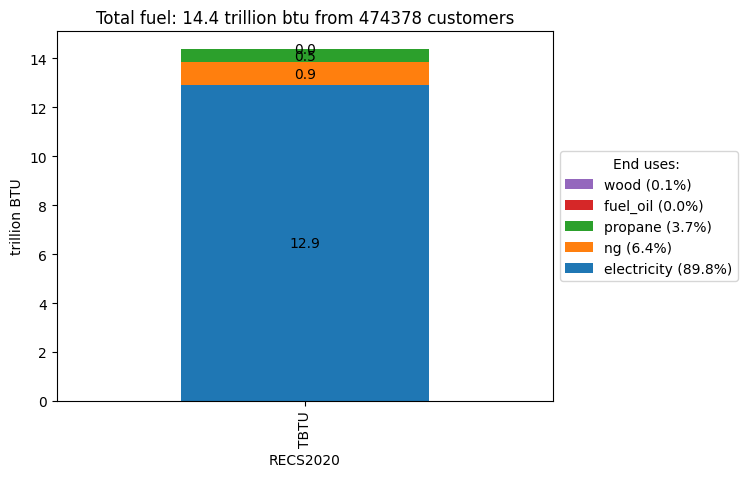

In [211]:
##RECS 2020
data = total_df.set_index('fuel').drop(['end_use'], axis=1).drop('total').transpose()
ax = data.plot(kind="bar", stacked = True, ylabel = "trillion BTU", xlabel = "RECS2020")

labels = [f"{k} ({v:.1f})" for k, v in data.transpose().to_dict()['TBTU'].items()]
for c in ax.containers:
    cols = [round(v.get_height(),1) if v.get_height() > 0 else '' for v in c]
    ax.bar_label(c, labels=cols, label_type='center')
h, l = ax.get_legend_handles_labels()
data_frac = data.transpose()/data.sum(axis=1) # normalize
labels = [f"{k} ({v*100:.01f}%)" for k, v in data_frac.to_dict()['TBTU'].items()]
# ax.text(fuels.values)
ax.legend(h[::-1], labels[::-1], loc="center left", bbox_to_anchor=(1, 0.5), title="End uses: ")
ax.set_title(f"Total fuel: {data.values.sum():.001f} trillion btu from {round(recs_hh_count, 0):.0f} customers")
ax.get_figure().savefig(output_dir / "stacked_fuel_uses_recs_2020.pdf", bbox_inches="tight")


Note: Electricity solar: combination of solar thermal and small-scale production (assumed behind-the-meter residential production consumed onsite)


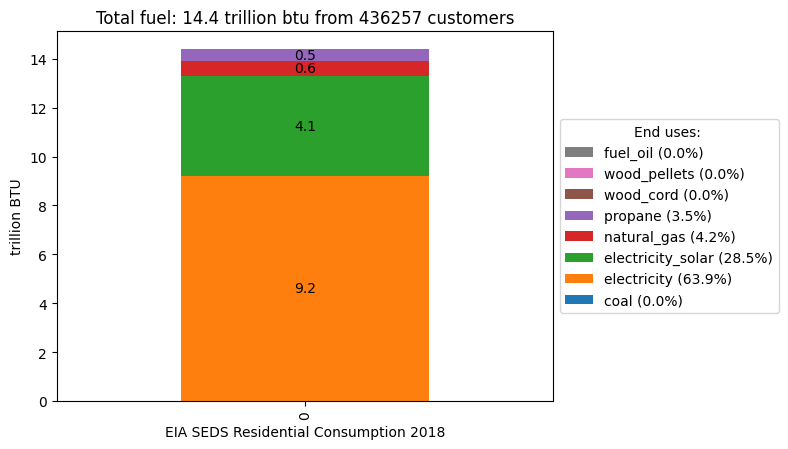

In [212]:
## EIA 2018 residential data for Hawaii: https://www.eia.gov/state/seds/data.php?incfile=/state/seds/sep_fuel/html/fuel_te.html&sid=US&sid=HI Table C5
fuels = {"coal": 0,"electricity": 9.2,"electricity_solar": 4.1,  "natural_gas": 0.6, "propane": 0.5,  "wood_cord": 0, "wood_pellets": 0, "fuel_oil": 0}
data = pd.DataFrame([fuels])
cust = eia_861_data["N_UNITS"].sum()
ax = data.plot(kind="bar", stacked = True, ylabel = "trillion BTU", xlabel = "EIA SEDS Residential Consumption 2018")
labels = [f"{k} ({v:.1f})" for k, v in fuels.items()]
for c in ax.containers:
    cols = [round(v.get_height(),2) if v.get_height() > 0 else '' for v in c]
    ax.bar_label(c, labels=cols, label_type='center')
h, l = ax.get_legend_handles_labels()
data_frac = data.transpose()/data.sum(axis=1) # normalize
labels = [f"{k} ({v*100:.01f}%)" for k, v in data_frac.to_dict()[0].items()]
# ax.text(fuels.values)
ax.legend(h[::-1], labels[::-1], loc="center left", bbox_to_anchor=(1, 0.5), title="End uses: ")
ax.set_title(f"Total fuel: {data.values.sum():.001f} trillion btu from {round(cust, 0):.0f} customers")
ax.get_figure().savefig(output_dir / "stacked_fuel_uses_eia_2018.pdf", bbox_inches="tight")

print("Note: Electricity solar: combination of solar thermal and small-scale production (assumed behind-the-meter residential production consumed onsite)")

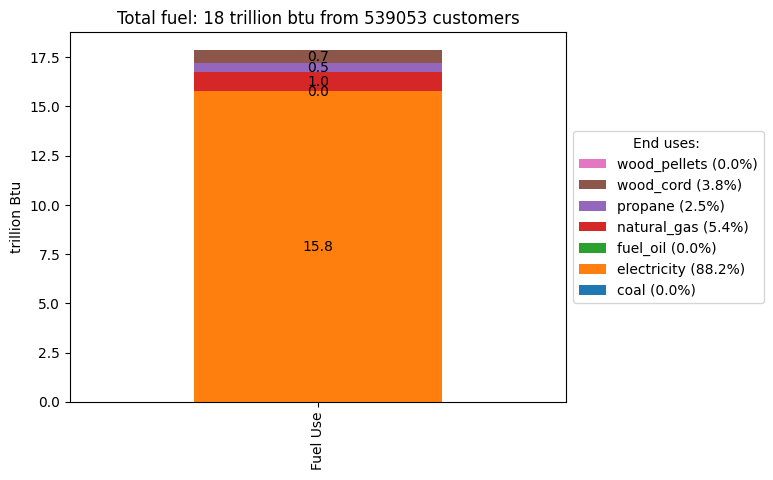

In [213]:
##TODO Add label indicating this is ResStock with run number LIXI
##TODO Pull out solar produced on site for a cleaner SEDS comparison LIXI
plot_normalized_stacked_fuel_uses(dfb, n_represented=N_UNITS, save_fig=True) 

In [214]:
## TODO COMPARISON OF RESSTOCK RECS and both EIA NORMALIZED BY HH LIXI

In [215]:
## TODO Summary table comparing how far off we are on total energy by end use and normalized by household (% difference) LIXI
## TODO PV Summary statistics - need to create LIXI

## End-Use Breakdown - STATE

In [216]:
# RECS 2020 Data Summary
recs_sum_end_use["percent_energy"] = recs_sum_end_use["TBTU"]/sum( recs_sum_end_use["TBTU"])
for fuel in recs_sum_end_use.index:
    recs_sum_end_use.loc[fuel,"percent_fuel"] = recs_sum_end_use.loc[fuel,"TBTU"]/recs_sum_end_use.loc[fuel[0], "TBTU"].sum()

recs_sum_end_use["kWh/hh"] = recs_sum_end_use["TBTU"]/recs_hh_count/MBTU_TO_TBTU*MBTU_TO_KWH
recs_sum_end_use.loc["electricity",:].sum()
recs_sum_end_use = recs_sum_end_use.rename(index={'subset':'other'})

/var/folders/zw/lhnn73fj2250g9z11h_whq1szkf2pm/T/ipykernel_16371/3182322636.py:4: RuntimeWarning: invalid value encountered in scalar divide
  recs_sum_end_use.loc[fuel,"percent_fuel"] = recs_sum_end_use.loc[fuel,"TBTU"]/recs_sum_end_use.loc[fuel[0], "TBTU"].sum()
/var/folders/zw/lhnn73fj2250g9z11h_whq1szkf2pm/T/ipykernel_16371/3182322636.py:4: RuntimeWarning: invalid value encountered in scalar divide
  recs_sum_end_use.loc[fuel,"percent_fuel"] = recs_sum_end_use.loc[fuel,"TBTU"]/recs_sum_end_use.loc[fuel[0], "TBTU"].sum()


In [217]:
recs_sum_end_use

TBTU  percent_energy  percent_fuel  \
fuel        summary_end_use                                           
electricity cooling          3.108107        0.216094      0.240747   
            laundry          0.678748        0.047191      0.052574   
            other            4.978027        0.346102      0.385587   
            refrigerator     1.753999        0.121949      0.135861   
            water_heating    2.391392        0.166264      0.185232   
fuel_oil    other            0.000000        0.000000           NaN   
            water_heating    0.000000        0.000000           NaN   
ng          laundry          0.026477        0.001841      0.028619   
            other            0.123799        0.008607      0.133818   
            water_heating    0.774854        0.053873      0.837562   
propane     laundry          0.020476        0.001424      0.038511   
            other            0.168147        0.011691      0.316243   
            water_heating    0.343079        0.023853      0.645246   
wood        other            0.015996        0.001112      1.000000   

                                  kWh/hh  
fuel        summary_end_use               
electricity cooling          1920.190797  
            laundry           419.331220  
            other            3075.428770  
            refrigerator     1083.621624  
            water_heating    1477.403683  
fuel_oil    other               0.000000  
            water_heating       0.000000  
ng          laundry            16.357255  
            other              76.483291  
            water_heating     478.705509  
propane     laundry            12.650367  
            other             103.881315  
            water_heating     211.954515  
wood        other               9.882496

In [218]:
# ResStock run end use summary
fuels = ["electricity", "natural_gas", "propane", "fuel_oil", "wood_cord", "wood_pellets"]#, "coal"]
enduse_cols, mapped_cols = [], []

for fu in fuels:
    eu_cols = [col for col in dfb.columns if f"end_use_{fu}" in col]
    enduse_cols += eu_cols
    if fu == 'wood_cord' or fu=='wood_pellets':
        fu_n = 'wood'
    else:
        fu_n = fu
    mapped_cols += [(fu_n, enduse_summary_dict[
        col.removeprefix(f"report_simulation_output.end_use_{fu}_").removesuffix("_m_btu")
        ] )for col in eu_cols]

df = dfb[enduse_cols].rename(columns=dict(zip(enduse_cols, mapped_cols))).groupby(level=0, axis=1).sum()

resstock_end_use = df.sum().drop(('electricity', 'pv_gen'))*dfb['build_existing_model.sample_weight'][0]*MBTU_TO_TBTU
resstock_end_use.index = pd.MultiIndex.from_tuples(resstock_end_use.index)
### CONFIRM UNITS

/var/folders/zw/lhnn73fj2250g9z11h_whq1szkf2pm/T/ipykernel_16371/2041132753.py:16: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df = dfb[enduse_cols].rename(columns=dict(zip(enduse_cols, mapped_cols))).groupby(level=0, axis=1).sum()


In [219]:
## Pull HERO Data
HERO = pd.read_csv("data/HERO.csv")
HERO_sum = HERO.groupby("Aggregated").sum().loc[:,['State']]#, 'Oahu']]

In [220]:
## RECS vs HERO vs ResStock
end_use = pd.concat([recs_sum_end_use.loc["electricity", "percent_fuel"], HERO_sum, resstock_end_use['electricity']/resstock_end_use['electricity'].sum()], axis = 1)
end_use.columns = ["RECS", 'UHERO State','ResStock']#, 'UHERO Oahu']
end_use

,RECS,UHERO State,ResStock
cooling,0.240747,0.14,0.351486
laundry,0.052574,0.11,0.049064
other,0.385587,0.36,0.411867
refrigerator,0.135861,0.21,0.080789
water_heating,0.185232,0.18,0.106794


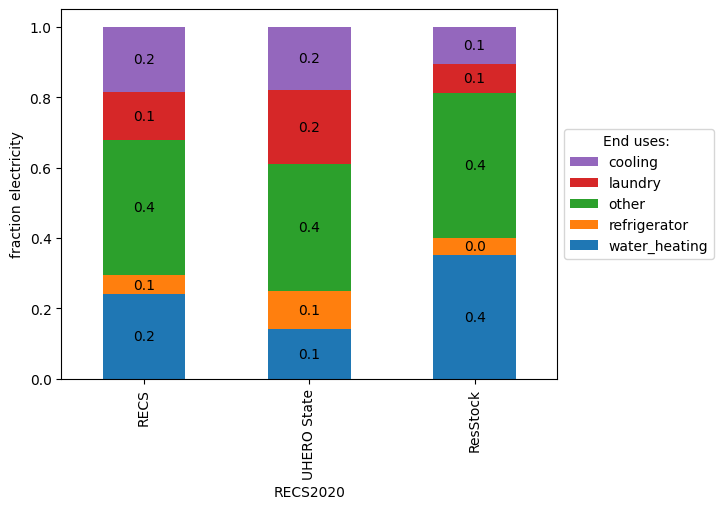

In [221]:
ax = end_use.transpose().plot(kind="bar", stacked = True, ylabel = "fraction electricity", xlabel = "RECS2020")

# labels = [f"{k} ({v:.1f})" for k, v in data.transpose().to_dict()['TBTU'].items()]
for c in ax.containers:
    cols = [round(v.get_height(),1) if v.get_height() > 0 else '' for v in c]
    ax.bar_label(c, labels=cols, label_type='center')
h, l = ax.get_legend_handles_labels()
ax.legend(h[::-1], l, loc="center left", bbox_to_anchor=(1, 0.5), title="End uses: ")

## SOrt by same to different

In [222]:
## TODO STACKED % BAR CHART OF RECS, HERO, ResStock for electricity end use JANET

/var/folders/zw/lhnn73fj2250g9z11h_whq1szkf2pm/T/ipykernel_16371/2743294284.py:71: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df = dfb[enduse_cols].rename(columns=dict(zip(enduse_cols, mapped_cols))).groupby(level=0, axis=1).sum()
/var/folders/zw/lhnn73fj2250g9z11h_whq1szkf2pm/T/ipykernel_16371/2743294284.py:71: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df = dfb[enduse_cols].rename(columns=dict(zip(enduse_cols, mapped_cols))).groupby(level=0, axis=1).sum()
/var/folders/zw/lhnn73fj2250g9z11h_whq1szkf2pm/T/ipykernel_16371/2743294284.py:71: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df = dfb[enduse_cols].rename(columns=dict(zip(enduse_cols, mapped_cols))).groupby(level=0, axis=1).sum()
/var/folders/zw/lhnn73fj2250g9z11h_whq1szkf2pm/T/ipykernel_16371/2743294284.py:71: FutureWarning: DataFram

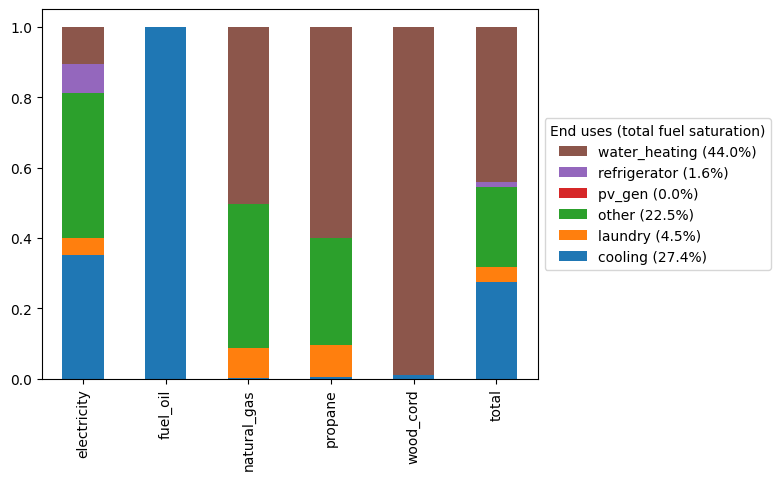

In [223]:
plot_normalized_stacked_summary_end_uses_by_fuel(dfb)

In [224]:
## TODO STACKED PER HH BAR CHART FOR RECS and ResSTOCK for NG, Propane, Fuel Oil, Wood JANET

/var/folders/zw/lhnn73fj2250g9z11h_whq1szkf2pm/T/ipykernel_16371/2743294284.py:41: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df = dfb[enduse_cols].rename(columns=dict(zip(enduse_cols, mapped_cols))).groupby(level=0, axis=1).sum()
/var/folders/zw/lhnn73fj2250g9z11h_whq1szkf2pm/T/ipykernel_16371/2743294284.py:41: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df = dfb[enduse_cols].rename(columns=dict(zip(enduse_cols, mapped_cols))).groupby(level=0, axis=1).sum()
/var/folders/zw/lhnn73fj2250g9z11h_whq1szkf2pm/T/ipykernel_16371/2743294284.py:41: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df = dfb[enduse_cols].rename(columns=dict(zip(enduse_cols, mapped_cols))).groupby(level=0, axis=1).sum()
/var/folders/zw/lhnn73fj2250g9z11h_whq1szkf2pm/T/ipykernel_16371/2743294284.py:41: FutureWarning: DataFram

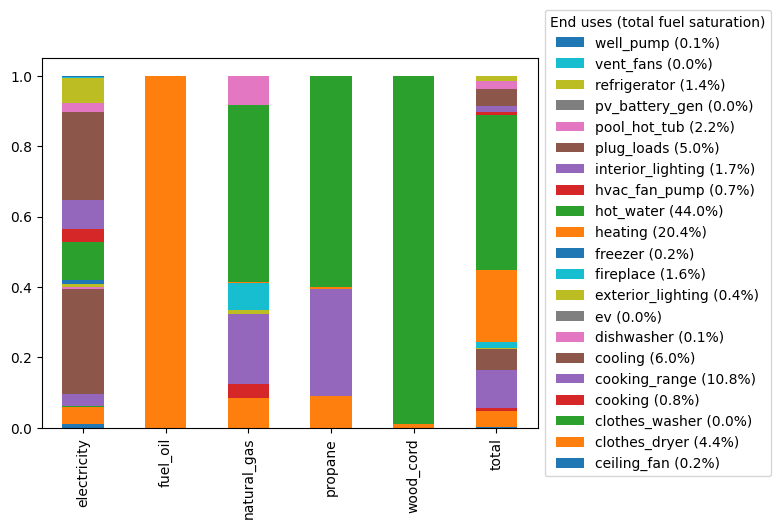

In [225]:
## Why are we getting fuel oil in this plot?
## Heating seems high - 20 % I THINK SOMETHING IS WRONG WITH THE HEATING TOTAL PLOT JANET
plot_normalized_stacked_end_uses_by_fuel(dfb, save_fig=True)

In [226]:
##TODO: county-level end use comparisons ResStock vs UHERO

In [227]:
# Electricity Stats, comparison to utility
print("-- ResStock Total Electricity --")
n_customers = N_UNITS
avg_elec_kwh = (dfb["report_simulation_output.fuel_use_electricity_total_m_btu"]*MBTU_TO_KWH).mean()
total_elec_mwh = avg_elec_kwh*n_customers*KWH_TO_MWH
print(f"{total_elec_mwh:.0f} MWh for {n_customers} customers")

print(f"\n-- EIA Form 861 2018 -- All Hawaii") #{eianame} (utility no: {eiaid})")
print(f"{ eia_861_data.N_MWH.sum() } MWh for {eia_861_data.N_UNITS.sum()} customers")

print("\n-- Delta --")
delta = (total_elec_mwh - eia_861_data.N_MWH.sum())/eia_861_data.N_MWH.sum()
print(f"Difference: {delta*100:.02f} %")

## TODO: Add normalized percent difference too Move to section above LIXI

-- ResStock Total Electricity --
4619822 MWh for 539053 customers

-- EIA Form 861 2018 -- All Hawaii
2585507 MWh for 436257 customers

-- Delta --
Difference: 78.68 %


-- Dwelling Unit Electricity [kWh] --
count     7502.000000
mean      8570.254954
std       5935.510338
min          0.000000
25%       4567.878965
50%       7191.524451
75%      11305.729400
max      45798.216109
Name: report_simulation_output.fuel_use_electricity_total_m_btu, dtype: float64


/var/folders/zw/lhnn73fj2250g9z11h_whq1szkf2pm/T/ipykernel_16371/2743294284.py:17: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  df = dfb[enduse_cols].rename(columns=dict(zip(enduse_cols, mapped_cols))).groupby(level=0, axis=1).sum()


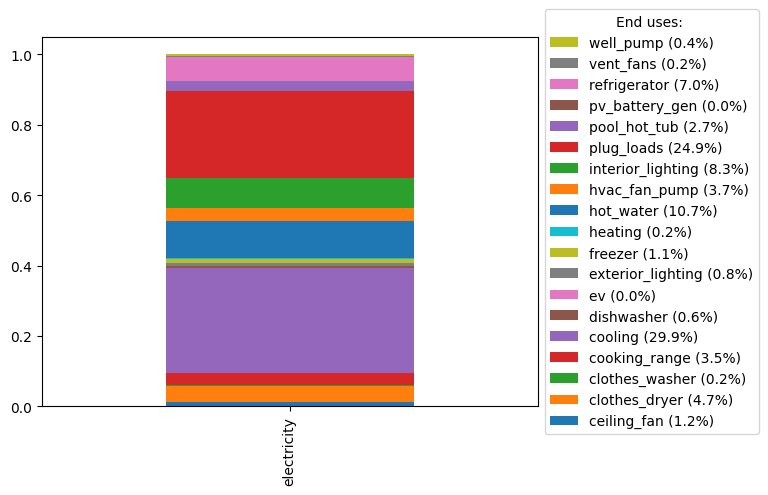

In [228]:
print("-- Dwelling Unit Electricity [kWh] --")
print((dfb["report_simulation_output.fuel_use_electricity_total_m_btu"]*MBTU_TO_KWH).describe())
## ADD in IQR Stats for RECS Janet

plot_normalized_stacked_end_uses(dfb, fuel="electricity", save_fig=True)
# MOVE TO BE WITH OTHER ELECTRICITY PLOTS, PULL RECS FOR COMPARISON JANET

### 3. Monthly End Use Breakdown STATE

In [229]:
if monthly_file.exists():
    df_monthly = pd.read_csv(monthly_file)

else:
    fuels = ["electricity", "natural_gas", "propane", "fuel_oil", "wood_cord", "wood_pellets", "coal"]
    ts_eu_cols = [x.name for x in bsq.ts_table.columns if "end_use" in x.name] # Make sure BSQ initialized earlier in script TSV
    
    fuel_dicts = []
    n_to_check = 0
    for fuel in fuels:
        ts_eu_cols_fuel  = [col for col in ts_eu_cols if fuel in col]
        fuel_dict = defaultdict(lambda: [])
        for key, val in enduse_category_dict.items():
            eu_list = [col for col in ts_eu_cols_fuel if key == col.split("__")[2]]
            fuel_dict[val] += eu_list
            n_to_check += len(eu_list)
        fuel_dicts.append(fuel_dict)
    
    assert len(ts_eu_cols) == n_to_check, f"{n_to_check} / {len(ts_eu_cols)} timeseries end_use cols are accounted for in aggregation query"
    
    agg_ts_eu_query = []
    for fuel, fuel_dicts in zip(fuels, fuel_dicts):
        for col, eu_list in fuel_dicts.items():
            if eu_list:
                unit = eu_list[0].split("__")[-1]
                unit_query = "+".join([f'"{eu}"' for eu in eu_list]) 
                unit_query = f'SUM(({unit_query})*"weight") AS "{fuel}__{col}__{unit}"'
                agg_ts_eu_query.append(unit_query)
    
    agg_ts_eu_query = ", ".join(agg_ts_eu_query)
    query = f"""
    WITH selection AS (
        SELECT "building_id" AS "bldg_id", "build_existing_model.sample_weight" AS "weight" 
        FROM "{bsq.bs_table.name}"
        WHERE {restrict}
    ),
    total_weight AS (
        SELECT SUM("weight") AS "n_represented" FROM selection
    )

    SELECT MONTH("time") AS month, COUNT(DISTINCT "building_id") AS "n_simulated", AVG("n_represented") AS "n_represented",
        {agg_ts_eu_query}
    FROM ("{bsq.ts_table.name}" RIGHT JOIN selection ON "building_id" = "bldg_id") CROSS JOIN total_weight
    GROUP BY 1
    ORDER BY 1
    """

    df_monthly = bsq.execute(query)
    df_monthly.to_csv(monthly_file, index=False)

    

# Unit conversion to tbtu
kwh_cols = [x for x in df_monthly.columns if x.endswith("__kwh")]
kbtu_cols = [x for x in df_monthly.columns if x.endswith("__kbtu")]
df_monthly[kwh_cols] *= KWH_TO_TBTU
df_monthly[kbtu_cols] *= KBTU_TO_TBTU
name_changes = dict(zip(kwh_cols, [x.removesuffix("__kwh")+"__tbtu" for x in kwh_cols]))
name_changes |= dict(zip(kbtu_cols, [x.removesuffix("__kbtu")+"__tbtu" for x in kbtu_cols]))
df_monthly.rename(columns=name_changes, inplace=True)


In [230]:
df_monthly_eia_elec = pd.read_csv(output_dir.parent / "eia_form_861M_electricity_sales_by_state_2018_with_solar.csv")
df_monthly_eia_elec # total generation = sales + solar generation

##TODO: commit solar data file LIXI

,Year,Month,State,Sales (Megawatthours),Customer (Count),Residential Capacity MW,Residential Generation MWh,Residential Total Generation (MWh)
0,2018,1,HI,224849.55,435777,361.51,45190.08,270039.63
1,2018,2,HI,194325.73,435878,362.68,43539.39,237865.12
2,2018,3,HI,217464.92,436229,363.38,52596.27,270061.19
3,2018,4,HI,218877.52,436463,364.27,54781.39,273658.91
4,2018,5,HI,210248.84,436585,364.99,57852.08,268100.92
5,2018,6,HI,218916.00,436063,366.04,58653.12,277569.12
6,2018,7,HI,240194.85,435901,366.69,59226.94,299421.79
7,2018,8,HI,254770.45,436104,367.13,57399.03,312169.48
8,2018,9,HI,244066.94,436100,367.81,53436.94,297503.88
9,2018,10,HI,243415.23,436654,368.76,49638.17,293053.40


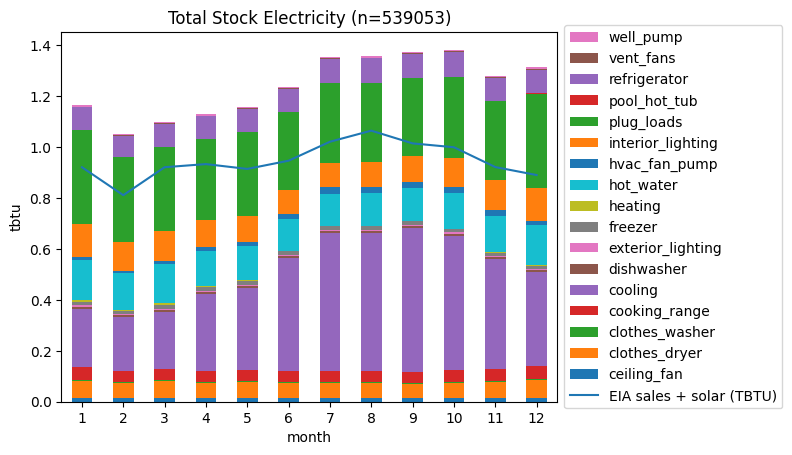

In [231]:
fuel = "electricity"
mdata_eia_elec = (df_monthly_eia_elec.set_index("Month")["Residential Total Generation (MWh)"]*MWH_TO_TBTU).rename("EIA sales + solar (TBTU)")
plot_monthly_total_stacked_end_uses(df_monthly, fuel, data_eia=mdata_eia_elec, n_represented=N_UNITS, save_fig=True)

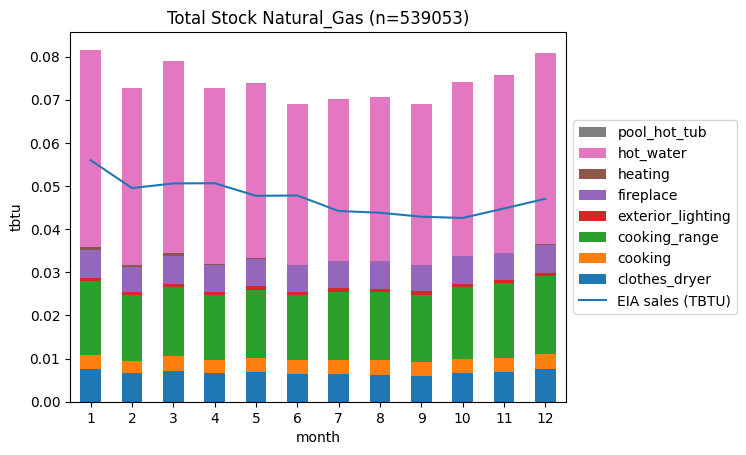

In [232]:
fuel = "natural_gas"
df_monthly_eia_gas = pd.read_csv(output_dir.parent / "eia_natural_gas_by_state_kbtu_2018.csv")
mdata_eia_gas = (df_monthly_eia_gas.iloc[:, 3:].iloc[0, ::-1]*KBTU_TO_TBTU).rename("EIA sales (TBTU)")
plot_monthly_total_stacked_end_uses(df_monthly, fuel, data_eia=mdata_eia_gas, n_represented=N_UNITS, save_fig=True)

In [233]:
# fuel = "propane"
# plot_monthly_total_stacked_end_uses(df_monthly, fuel, n_represented=N_UNITS, save_fig=True)

In [234]:
## Monthly End Use Breakdown - COUNTY (electricity only) TODO: LIXI

### 4. Seasonal diurnal plots

In [235]:
## TODO - break these plots up by County / Island YINGLI

In [236]:
if diurnal_file.exists():
    df_ts = pd.read_csv(diurnal_file)

else:
    query = f"""
    WITH selection AS (
        SELECT "building_id" AS "bldg_id", "build_existing_model.sample_weight" AS "weight" 
        FROM "{bsq.bs_table.name}"
        WHERE {restrict}
    ),
    total_weight AS (
        SELECT SUM("weight") AS "n_represented" FROM selection
    )

    SELECT MONTH("time") AS "month", DAY_OF_WEEK("time") AS "day_of_week", HOUR("time") AS "hour", 
        COUNT(DISTINCT "time") AS "n_timestamps", COUNT(DISTINCT MINUTE("time")) AS "int_per_hour",
        COUNT(DISTINCT "building_id") AS "n_simulated", AVG("n_represented") AS "n_represented",
        {agg_ts_eu_query}
    FROM ("{bsq.ts_table.name}" RIGHT JOIN selection ON "building_id" = "bldg_id") CROSS JOIN total_weight
    GROUP BY 1, 2, 3
    ORDER BY 1, 2, 3
    """
    # 1 (Monday) to 7 (Sunday)
    df_ts = bsq.execute(query)
    df_ts.to_csv(diurnal_file, index=False)
    
df_ts

,month,day_of_week,hour,n_timestamps,int_per_hour,n_simulated,n_represented,electricity__ceiling_fan__kwh,electricity__clothes_dryer__kwh,electricity__clothes_washer__kwh,...,natural_gas__hot_water__kbtu,natural_gas__exterior_lighting__kbtu,natural_gas__cooking_range__kbtu,propane__clothes_dryer__kbtu,propane__heating__kbtu,propane__hot_water__kbtu,propane__cooking_range__kbtu,fuel_oil__heating__kbtu,wood_cord__heating__kbtu,wood_cord__hot_water__kbtu
0,1,1,0,4,1,7502,1447154.0,77712.864249,164258.344780,3388.331113,...,5.827947e+05,18285.606767,29327.534535,43936.421062,1246.921282,309170.891059,18400.962418,0.0,4088.374017,7.795152e+05
1,1,1,1,5,1,7502,1447154.0,80948.030836,154699.450864,4621.749225,...,5.148764e+05,15470.774567,30286.645397,22392.499417,4380.042485,263542.137014,17530.393769,0.0,11820.481959,7.026506e+05
2,1,1,2,5,1,7502,1447154.0,74313.344795,82515.555949,1354.753738,...,4.659718e+05,8101.901893,9099.593240,9981.736034,12018.592751,230262.996282,15787.520350,0.0,21623.590347,6.361013e+05
3,1,1,3,5,1,7502,1447154.0,71409.970381,32541.096050,598.383326,...,4.391073e+05,6683.104549,5996.757718,4711.448853,15936.826828,212242.823252,13388.585780,0.0,38268.561981,6.484762e+05
4,1,1,4,5,1,7502,1447154.0,70222.270144,16421.011917,899.504013,...,4.549058e+05,5272.023303,34907.430110,9828.185703,27353.756912,209068.613832,33507.151400,0.0,77128.562800,5.962454e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011,12,7,19,5,1,7502,1447154.0,116957.898310,546441.839576,25853.940550,...,1.083488e+06,23202.303802,463172.228043,125654.518383,0.000000,647147.322689,348154.156529,0.0,0.000000,1.484889e+06
2012,12,7,20,5,1,7502,1447154.0,131062.730798,566795.939057,27270.423064,...,1.032343e+06,26721.808564,275983.957687,102285.546885,0.000000,631743.485264,216829.464236,0.0,0.000000,1.446134e+06
2013,12,7,21,5,1,7502,1447154.0,134138.752884,556082.909926,24375.343454,...,1.028179e+06,28483.007714,153395.237561,98607.283425,0.000000,597294.777123,156307.678389,0.0,0.000000,1.412506e+06
2014,12,7,22,5,1,7502,1447154.0,131197.955399,448345.361774,11938.538244,...,9.182971e+05,30230.703694,114062.047091,84446.316331,0.000000,534781.659533,95722.041840,0.0,0.000000,1.311799e+06


In [237]:
seasons = {
    "winter": [2, 3, 4],
    "summer": [7, 8, 9, 10],
    "shoulder": [5, 6, 11, 12, 1],
}
season_map = {}
for key, val in seasons.items():
    for m in val:
        season_map[m] = key

df_ts["day_type"] = df_ts["day_of_week"].map(lambda x: "weekend" if x>5 else "weekday")
df_ts["season"] = df_ts["month"].map(season_map)
df_ts["n_hours"] = df_ts["n_timestamps"].div(df_ts["int_per_hour"])

df_ts


,month,day_of_week,hour,n_timestamps,int_per_hour,n_simulated,n_represented,electricity__ceiling_fan__kwh,electricity__clothes_dryer__kwh,electricity__clothes_washer__kwh,...,propane__clothes_dryer__kbtu,propane__heating__kbtu,propane__hot_water__kbtu,propane__cooking_range__kbtu,fuel_oil__heating__kbtu,wood_cord__heating__kbtu,wood_cord__hot_water__kbtu,day_type,season,n_hours
0,1,1,0,4,1,7502,1447154.0,77712.864249,164258.344780,3388.331113,...,43936.421062,1246.921282,309170.891059,18400.962418,0.0,4088.374017,7.795152e+05,weekday,shoulder,4.0
1,1,1,1,5,1,7502,1447154.0,80948.030836,154699.450864,4621.749225,...,22392.499417,4380.042485,263542.137014,17530.393769,0.0,11820.481959,7.026506e+05,weekday,shoulder,5.0
2,1,1,2,5,1,7502,1447154.0,74313.344795,82515.555949,1354.753738,...,9981.736034,12018.592751,230262.996282,15787.520350,0.0,21623.590347,6.361013e+05,weekday,shoulder,5.0
3,1,1,3,5,1,7502,1447154.0,71409.970381,32541.096050,598.383326,...,4711.448853,15936.826828,212242.823252,13388.585780,0.0,38268.561981,6.484762e+05,weekday,shoulder,5.0
4,1,1,4,5,1,7502,1447154.0,70222.270144,16421.011917,899.504013,...,9828.185703,27353.756912,209068.613832,33507.151400,0.0,77128.562800,5.962454e+05,weekday,shoulder,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011,12,7,19,5,1,7502,1447154.0,116957.898310,546441.839576,25853.940550,...,125654.518383,0.000000,647147.322689,348154.156529,0.0,0.000000,1.484889e+06,weekend,shoulder,5.0
2012,12,7,20,5,1,7502,1447154.0,131062.730798,566795.939057,27270.423064,...,102285.546885,0.000000,631743.485264,216829.464236,0.0,0.000000,1.446134e+06,weekend,shoulder,5.0
2013,12,7,21,5,1,7502,1447154.0,134138.752884,556082.909926,24375.343454,...,98607.283425,0.000000,597294.777123,156307.678389,0.0,0.000000,1.412506e+06,weekend,shoulder,5.0
2014,12,7,22,5,1,7502,1447154.0,131197.955399,448345.361774,11938.538244,...,84446.316331,0.000000,534781.659533,95722.041840,0.0,0.000000,1.311799e+06,weekend,shoulder,5.0


In [238]:
df_ts["n_hours"].sum()

np.float64(8760.0)

#### 4.1. Per dwelling unit

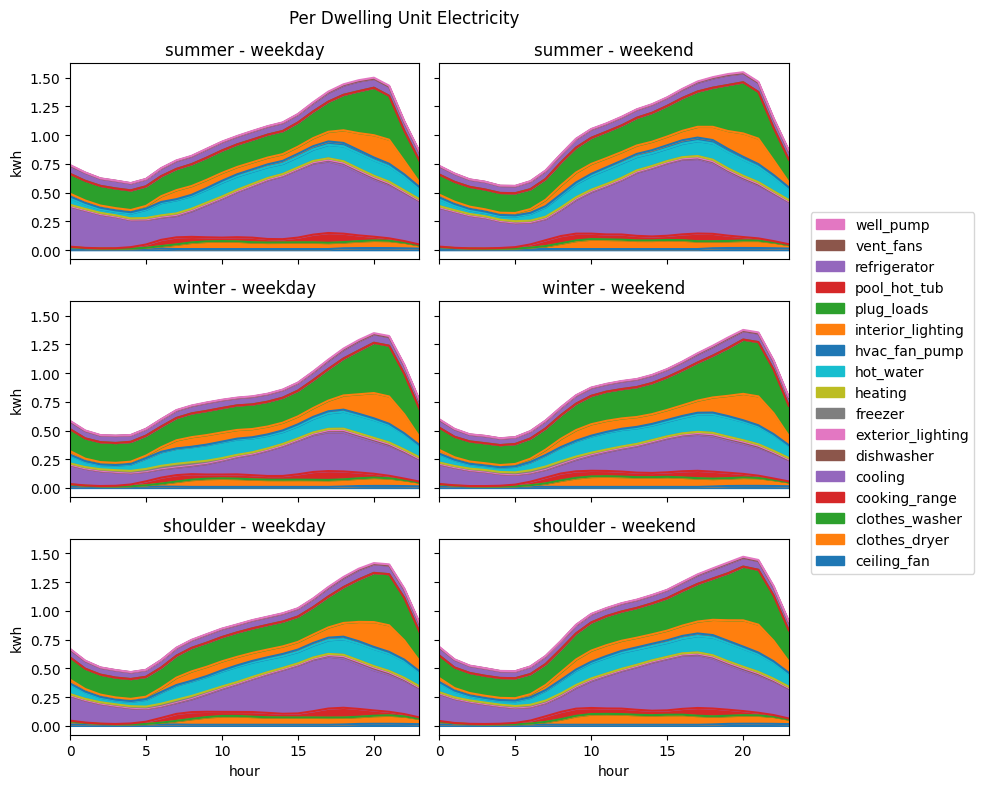

In [239]:
fuel = "electricity"
plot_seasonal_diurnal_end_uses(df_ts, fuel, stock_total=False, save_fig=True)

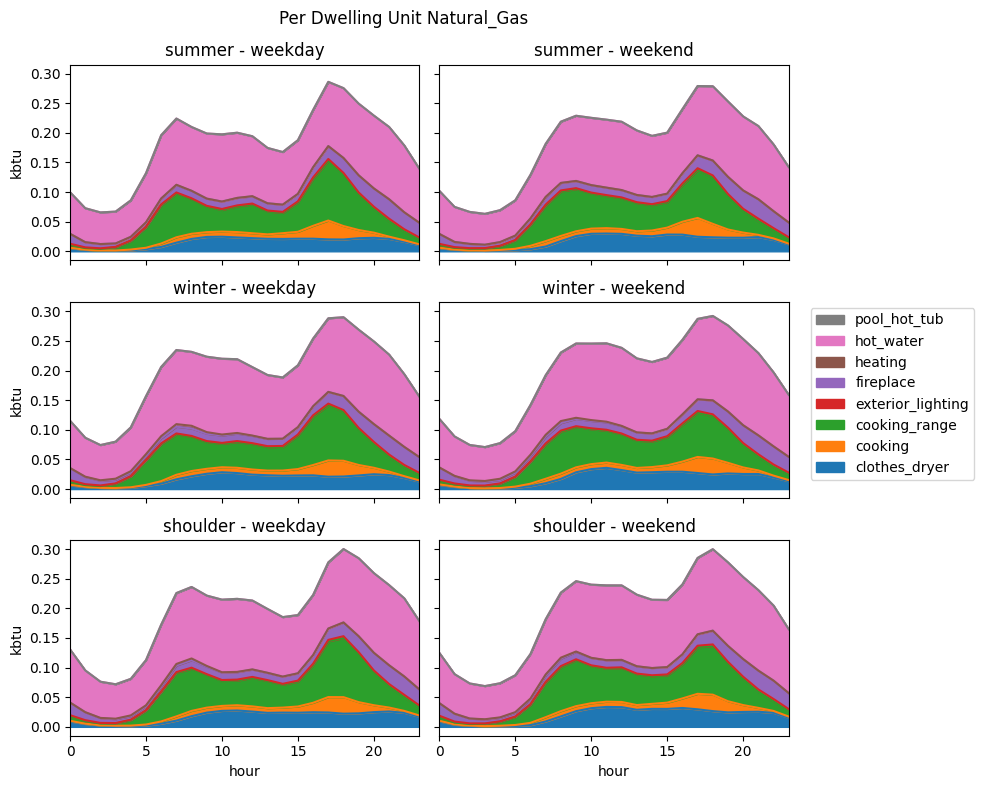

In [240]:
fuel = "natural_gas"
plot_seasonal_diurnal_end_uses(df_ts, fuel, stock_total=False, save_fig=True)

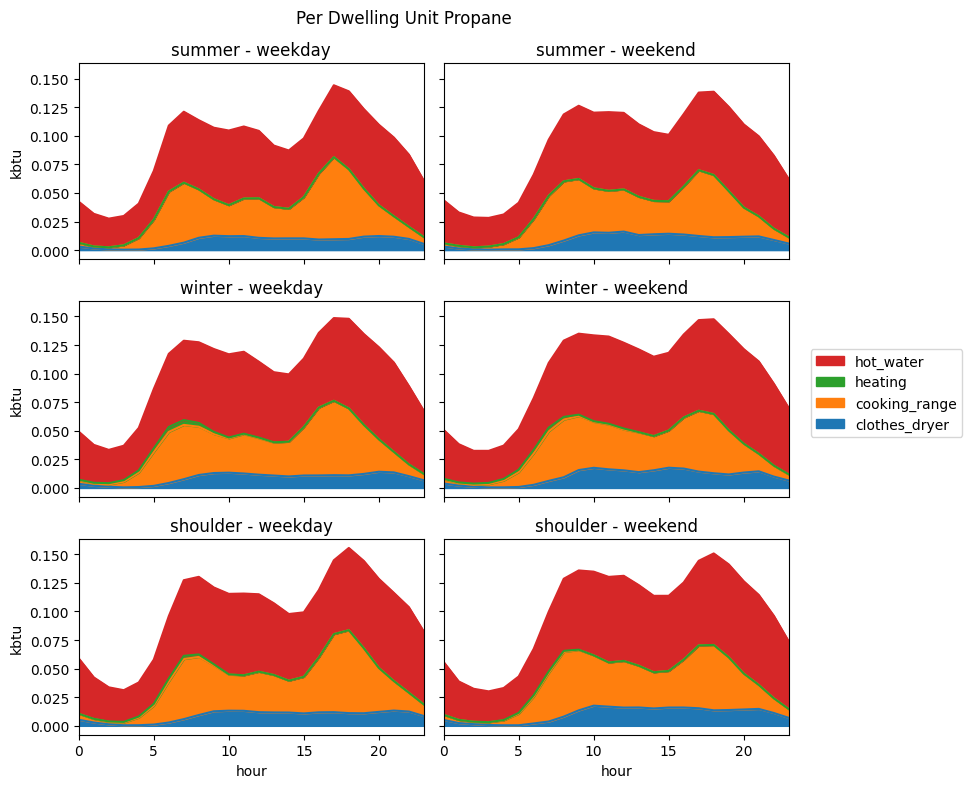

In [241]:
fuel = "propane"
plot_seasonal_diurnal_end_uses(df_ts, fuel, stock_total=False, save_fig=True)

#### 4.2 Total stock

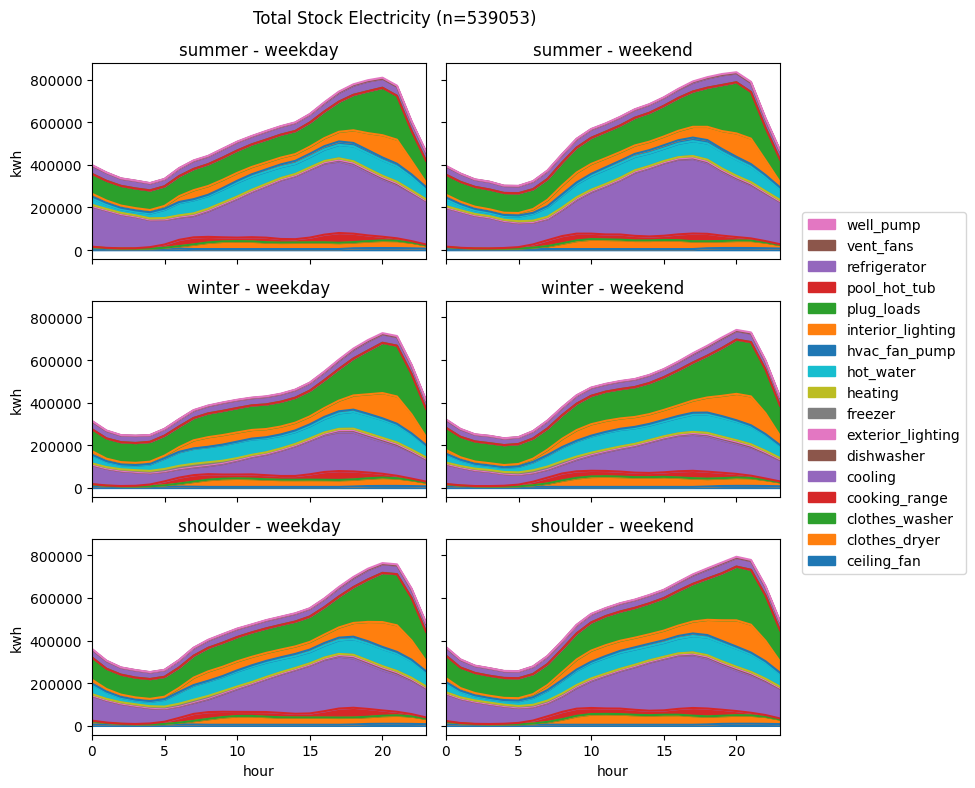

In [242]:
fuel = "electricity"
plot_seasonal_diurnal_end_uses(df_ts, fuel, stock_total=True, n_represented=N_UNITS, save_fig=True)

### 5. Aggregated baseline

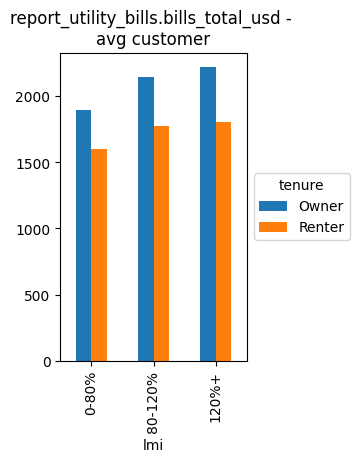

In [243]:
metric = "report_utility_bills.bills_total_usd" #"report_simulation_output.energy_use_total_m_btu"

groupby_cols = ["tenure", "lmi"]
plot_aggregated_metric(dfb, groupby_cols , metric, operation="mean")

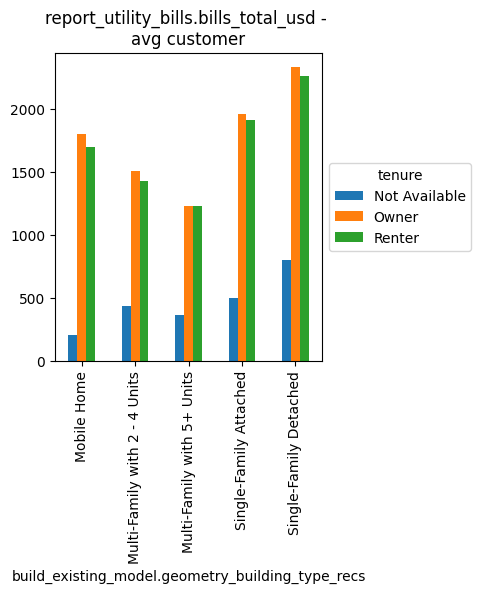

In [244]:
metric = "report_utility_bills.bills_total_usd" #"report_simulation_output.energy_use_total_m_btu"

groupby_cols = ["tenure", "build_existing_model.geometry_building_type_recs"]
plot_aggregated_metric(dfb, groupby_cols , metric, operation="mean")

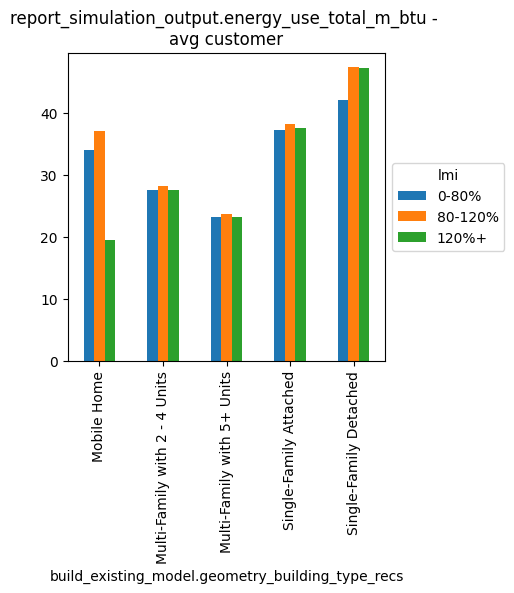

In [245]:
metric = "report_simulation_output.energy_use_total_m_btu" #"report_simulation_output.energy_use_total_m_btu" , "report_utility_bills.bills_total_usd"

groupby_cols = ["lmi", "build_existing_model.geometry_building_type_recs"]
plot_aggregated_metric(dfb, groupby_cols , metric, operation="mean")

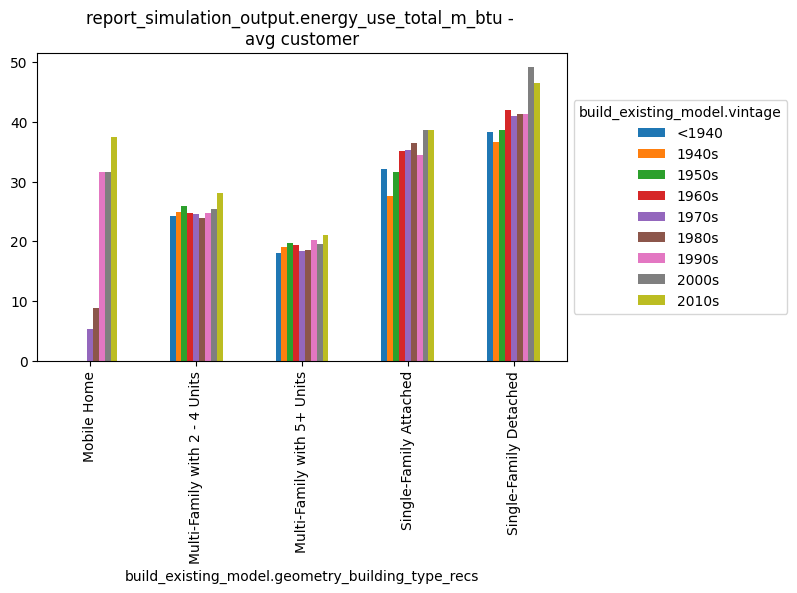

In [246]:
metric = "report_simulation_output.energy_use_total_m_btu" #"report_simulation_output.energy_use_total_m_btu" , "report_utility_bills.bills_total_usd"

groupby_cols = ["build_existing_model.vintage", "build_existing_model.geometry_building_type_recs"] # iqr_cohort_electricity
plot_aggregated_metric(dfb, groupby_cols , metric, operation="mean")

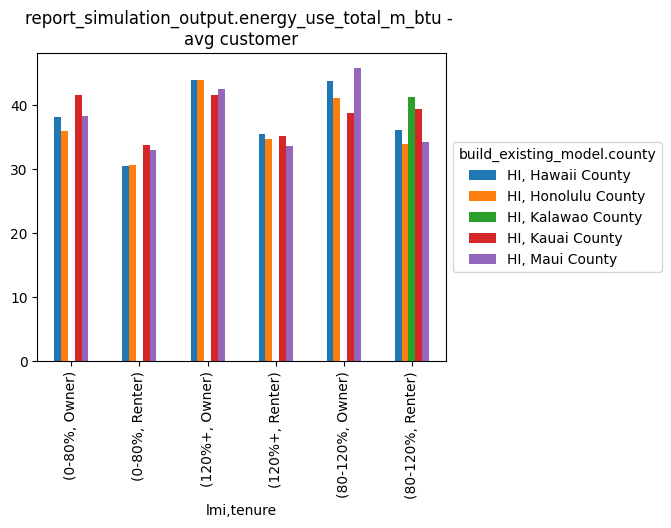

In [247]:
metric = "report_simulation_output.energy_use_total_m_btu" #"report_simulation_output.energy_use_total_m_btu" , "report_utility_bills.bills_total_usd"

groupby_cols = ["build_existing_model.county", "lmi", "tenure"] #"build_existing_model.income_recs_2020"] # iqr_cohort_electricity
plot_aggregated_metric(dfb, groupby_cols , metric, operation="mean")

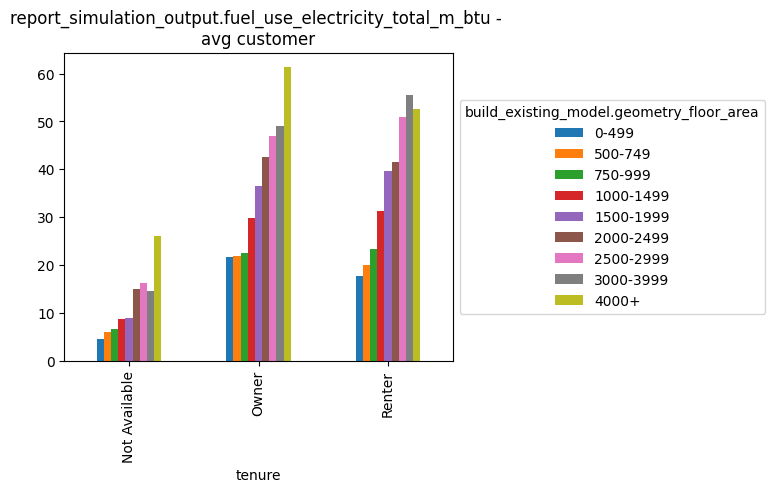

In [248]:
metric = "report_simulation_output.fuel_use_electricity_total_m_btu" #"report_simulation_output.energy_use_total_m_btu" , "report_utility_bills.bills_total_usd"

groupby_cols = ["build_existing_model.geometry_floor_area", "tenure"] # iqr_cohort_electricity
plot_aggregated_metric(dfb, groupby_cols , metric, operation="mean")

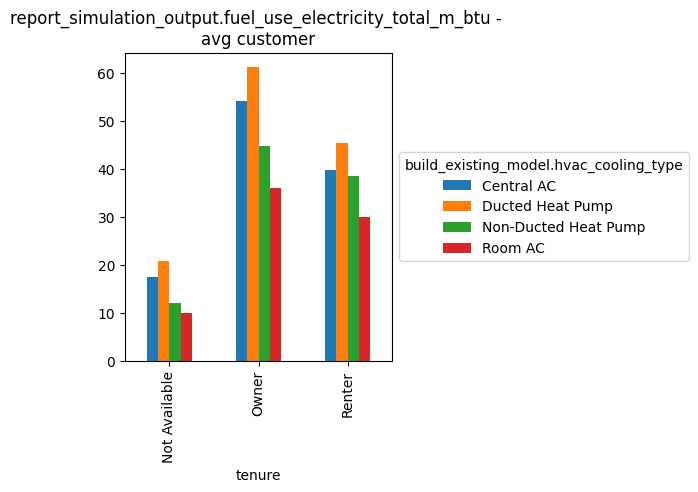

In [249]:
metric = "report_simulation_output.fuel_use_electricity_total_m_btu" #"report_simulation_output.energy_use_total_m_btu" , "report_utility_bills.bills_total_usd"

groupby_cols = ["build_existing_model.hvac_cooling_type", "tenure"] # iqr_cohort_electricity
plot_aggregated_metric(dfb, groupby_cols , metric, operation="mean")

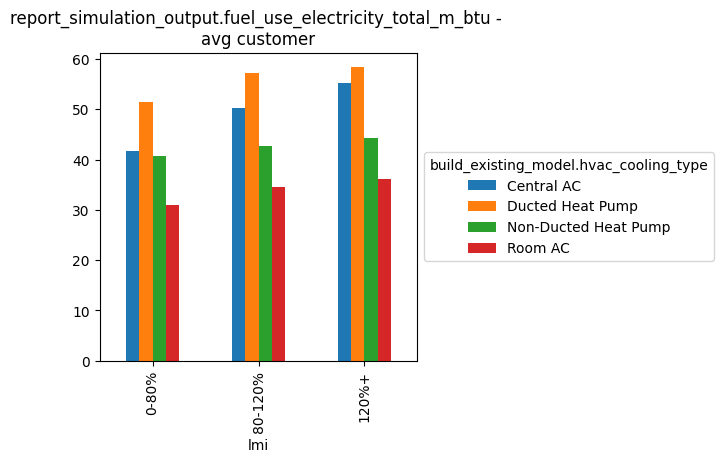

In [250]:
metric = "report_simulation_output.fuel_use_electricity_total_m_btu" #"report_simulation_output.energy_use_total_m_btu" , "report_utility_bills.bills_total_usd"

groupby_cols = ["build_existing_model.hvac_cooling_type", "lmi"] # iqr_cohort_electricity
plot_aggregated_metric(dfb, groupby_cols , metric, operation="mean")

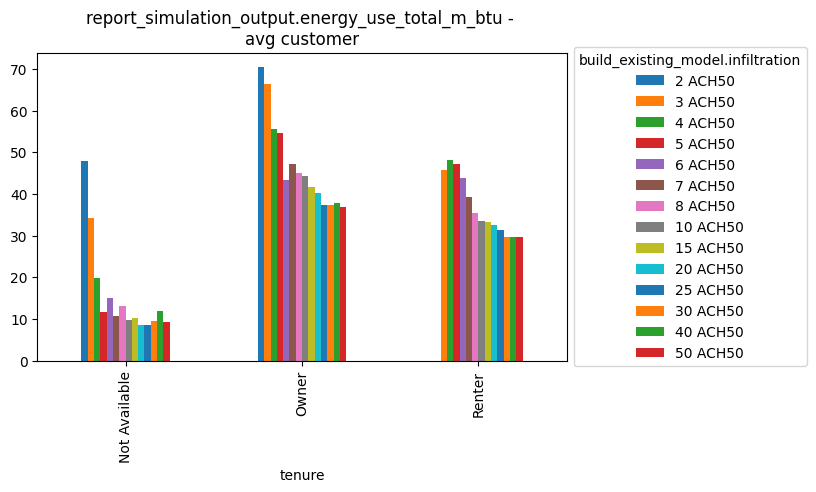

In [251]:
metric = "report_simulation_output.energy_use_total_m_btu" #"report_simulation_output.energy_use_total_m_btu" , "report_utility_bills.bills_total_usd"

groupby_cols = ["build_existing_model.infiltration", "tenure"] # iqr_cohort_electricity
plot_aggregated_metric(dfb, groupby_cols , metric, operation="mean")

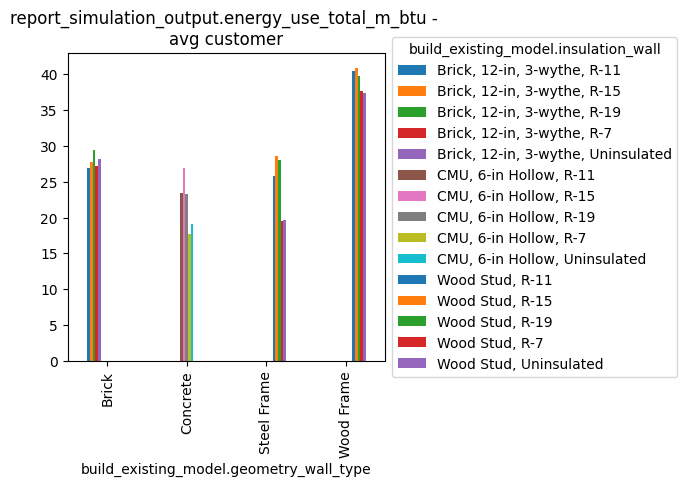

In [252]:
metric = "report_simulation_output.energy_use_total_m_btu" #"report_simulation_output.energy_use_total_m_btu" , "report_utility_bills.bills_total_usd"

groupby_cols = ["build_existing_model.insulation_wall", "build_existing_model.geometry_wall_type"] # iqr_cohort_electricity
plot_aggregated_metric(dfb, groupby_cols , metric, operation="mean")